# Color Space

본 파일에서는 Bloch Sphere에 Color Space를 정의하는 방법을 소개합니다.

## Import Packages

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble, Aer
from qiskit.visualization import plot_histogram

## Color Space Definiton

기존 color space는 Cartesian Coordinates에서 x,y,z 값에 각각 R,G,B 값을 할당하는 형태로 정육면체를 이루고 있었다.

그러나 Quantum Image Processing 에서는 Bloch Sphere의 표면 위에 R,G,B 값을 할당해야 하므로 규격화를 한 다음 매핑한다.

In [24]:
class RGBMapping3D_cart:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB 값에 해당하는 좌표를 점으로 플로팅
        points = np.array([point[0] for point in self.color_list])
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(30,60)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

In [26]:
classic_color_list = []
classic_color_index = []
for i in tqdm(range(0,256)):
    for j in range(0,256):
        for k in range(0,256):
            classic_color_index.append([i,j,k])
            P = np.array([i,j,k])
            classic_color_list.append([P])

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [05:56<00:00,  1.39s/it]  



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



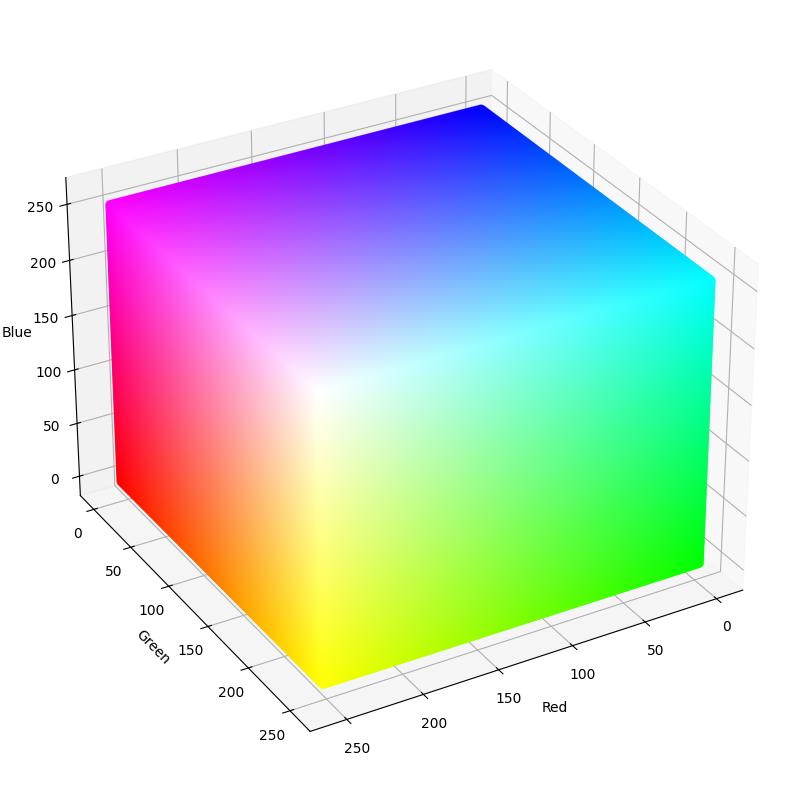

In [27]:
rgb_mapping_3d_classic = RGBMapping3D_cart(classic_color_index[:], classic_color_list[:])

# 좌표를 플로팅
rgb_mapping_3d_classic.plot_points()

# A novel RGB color space

### RGB 값을 Bloch Sphere에 매핑하는 식 구현하고, 전처리를 통해 중복값을 제거한 다음, Quantum Circuit으로 컬러 스페이스 표현

In [2]:
import numpy as np
from tqdm import tqdm
total_colors = 41942396
color_list = np.zeros((total_colors, 3), dtype=np.uint8)
color_coord = np.zeros((total_colors, 3), dtype=np.float32)
color_angle = np.zeros((total_colors, 2), dtype=np.float32)
index = 0
# Northen sphere
for a in tqdm(range(0, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(n, m+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k - n) * np.pi / (3 * (m - n))
            x,y,z = m,k,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(0, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(n, m+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n)) + 2*np.pi/3
            x,y,z = n,m,k
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(0, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(n, m+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n)) + 4*np.pi/3
            x,y,z = k,n,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(0, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(1, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + np.pi/3
            x,y,z = m-k,m,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(0, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(1, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 3 * np.pi/3
            x,y,z = n,m-k,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(0, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(1, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 5 *np.pi/3
            x,y,z = m,n,m-k
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

# Southern sphere
for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(n, m+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n))
            x,y,z = m,k,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(n, m+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n)) + 2*np.pi/3
            x,y,z = n,m,k
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(n, m+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n)) + 4*np.pi/3
            x,y,z = k,n,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(1, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + np.pi/3
            x,y,z = m-k, m, n 
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1
for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(1, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 3 * np.pi/3
            x,y,z = n, m-k, m
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(1, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 5 *np.pi/3
            x,y,z = m, n, m-k
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1


# Equator sphere
for a in tqdm(range(1, 255)):
    for i in range(0, 128):
        m = 255 - i
        n = i
        for k in range(n, m+1):
            theta = np.pi/2 + ((-1)**i) * np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n))
            x,y,z = m,k,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1
for a in tqdm(range(1, 255)):
    for i in range(0, 128):
        m = 255 - i
        n = i
        for k in range(n, m+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n)) + 2*np.pi/3
            x,y,z = n,m,k
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, 128):
        m = 255 - i
        n = i
        for k in range(n, m+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else (k-n)*np.pi/(3*(m-n)) + 4*np.pi/3
            x,y,z = k,n,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, 128):
        m = 255 - i
        n = i
        for k in range(1, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + np.pi/3
            x,y,z = m-k,m,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, 128):
        m = 255 - i
        n = i
        for k in range(1, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 3 * np.pi/3
            x,y,z = n,m-k,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, 128):
        m = 255 - i
        n = i
        for k in range(1, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 5 *np.pi/3
            x,y,z = m,n,m-k
            color_angle[index] = [theta, phi]
            color_coord[index] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

color_angle[index] = [0, 0]
color_coord[index] = [0, 0, 1]
color_list[index] = [0, 0, 0]
index += 1

color_angle[index] = [np.pi, 0]
color_coord[index] = [0, 0, -1]
color_list[index] = [255, 255, 255]
index += 1

  0%|          | 0/255 [00:00<?, ?it/s]

100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


In [3]:
print(f"Total colors added: {index}")
assert index == total_colors, f"Expected {total_colors} colors, but got {index}"

Total colors added: 41942396


In [4]:
len(color_list)

41942396

In [5]:
len(color_angle)

41942396

In [6]:
# 중복 제거
_, unique_indices = np.unique(color_list, axis=0, return_index=True)

# 중복이 제거된 배열 생성
color_list_unique = color_list[unique_indices]
color_angle_unique = color_angle[unique_indices]
color_coord_unique = color_coord[unique_indices]

# 메모리 해제
del color_list, color_angle, color_coord

# 필요한 경우에만 리스트로 변환
# unique_color_list = color_list_unique.tolist()
# unique_color_angle = color_angle_unique.tolist()
# unique_color_coord = color_coord_unique.tolist()

In [ ]:

# unique_color_angle은 이미 NumPy 배열이라고 가정합니다
theta = color_angle_unique[:, 0]
phi = color_angle_unique[:, 1]

print("theta:", theta)
print("phi:", phi)

theta: [0.0000000e+00 3.0799927e-03 1.2319971e-02 ... 3.1292727e+00 3.1385126e+00
 3.1415927e+00]
phi: [0.        4.1887903 4.1887903 ... 1.0471976 1.0471976 0.       ]


In [ ]:
import numpy as np
import pandas as pd

# 가정: unique_color_list, theta, phi는 이미 NumPy 배열로 존재합니다.

chunk_size = 524288
total_chunks = 32

for i in range(total_chunks):
    start = i * chunk_size
    end = (i + 1) * chunk_size

    # RGB 문자열 생성
    rgb_strings = [f"[{r}, {g}, {b}]" for r, g, b in color_list_unique[start:end]]

    # 데이터프레임 생성
    df = pd.DataFrame({
        "theta": theta[start:end],
        "phi": phi[start:end]
    }, index=rgb_strings)

    # 인덱스 이름 설정
    df.index.name = "RGB"

    # Excel 파일로 저장
    df.to_excel(f"color_space_angle{i*8}.xlsx", engine='openpyxl')

    # 메모리 정리
    del df
    del rgb_strings

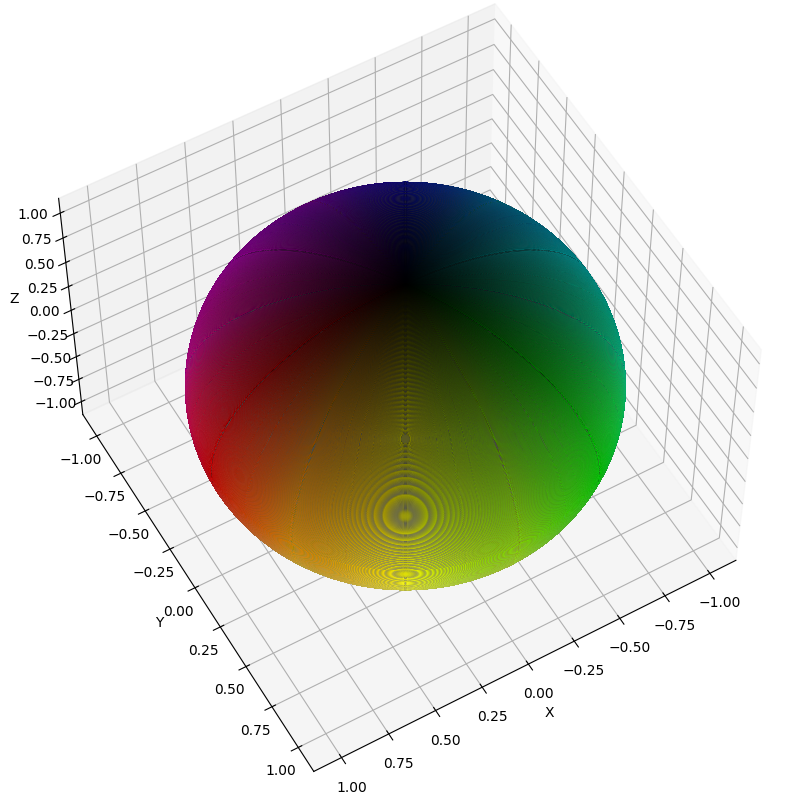

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class RGBMapping3D:
    def __init__(self, color_coord, color_list):
        self.color_coord = color_coord
        self.color_list = color_list

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        colors = self.color_list / 255.0  # Normalize color values

        ax.scatter(self.color_coord[:, 0], self.color_coord[:, 1], self.color_coord[:, 2], c=colors, marker='o')
        ax.view_init(55, 60)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        plt.show()

# 가정: color_coord_unique와 color_list_unique는 이미 NumPy 배열입니다
rgb_mapping_3d = RGBMapping3D(color_coord_unique, color_list_unique)

# Plot coordinates
rgb_mapping_3d.plot_points()

In [12]:
import pandas as pd

df = pd.read_excel('color_space_angle0.xlsx')
# 특정 인덱스 (예: first_index)를 사용하여 해당 theta 값을 가져오기
target_theta = df.loc[2, 'theta']
print(target_theta)
# 1. target_theta보다 작은 값 중에서 가장 큰 theta 값 (바로 이전 값)
previous_theta = df[df['theta'] < target_theta]['theta'].max()

# 2. target_theta보다 큰 값 중에서 가장 작은 theta 값 (바로 다음 값)
next_theta = df[df['theta'] > target_theta]['theta'].min()

# 결과 출력
print(f"기준 theta 값: {target_theta}")
print(f"바로 이전 theta 값: {previous_theta}")
print(f"바로 다음 theta 값: {next_theta}")

0.01231997087597847
기준 theta 값: 0.01231997087597847
바로 이전 theta 값: 0.009239978156983852
바로 다음 theta 값: 0.01539996359497309


In [104]:
import numpy as np
from tqdm import tqdm
total_colors = 17067922
color_list = np.zeros((total_colors, 3), dtype=np.uint8)
color_coord = np.zeros((total_colors, 3), dtype=np.float32)
color_angle = np.zeros((total_colors, 2), dtype=np.float32)
index = 0

r=1
# Northen sphere
for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(0, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k * np.pi / (3 * (m - n))
            x,y,z = m,n+k,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(0, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 2*np.pi/3
            x,y,z = n,m,n+k
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(0, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 4*np.pi/3
            x,y,z = n+k,n,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(0, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + np.pi/3
            x,y,z = m-k,m,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(0, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 3 * np.pi/3
            x,y,z = n,m-k,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - a - i
        n = i
        for k in range(0, m-n+1):
            theta = (255-a) * np.pi/510 + np.pi/1020 - np.pi/510*(i+1)/(np.floor((255-a)/2)+1)
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 5 *np.pi/3
            x,y,z = m,n,m-k
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

# Southern sphere
for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(0, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510 * (i+1)/ (int(np.floor((255-a)/2)+1))
            phi = 0 if m == n else k*np.pi/(3*(m-n))
            x,y,z = m,n+k,n
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(0, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510 * (i+1)/ (int(np.floor((255-a)/2)+1))
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 2*np.pi/3
            x,y,z = n,m,n+k
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(0, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510 * (i+1)/ (int(np.floor((255-a)/2)+1))
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 4*np.pi/3
            x,y,z = n+k,n,m
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(0, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510 * (i+1)/ (int(np.floor((255-a)/2)+1))
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + np.pi/3
            x,y,z = m-k, m, n 
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1
for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(0, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510 * (i+1)/ (int(np.floor((255-a)/2)+1))
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 3 * np.pi/3
            x,y,z = n, m-k, m
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1

for a in tqdm(range(1, 255)):
    for i in range(0, int(np.floor((255-a)/2))+1):
        m = 255 - i
        n = i + a
        for k in range(0, m-n+1):
            theta = (255+a) * np.pi/510 - np.pi/1020 + np.pi/510 * (i+1)/ (int(np.floor((255-a)/2)+1))
            phi = 0 if m == n else k*np.pi/(3*(m-n)) + 5 *np.pi/3
            x,y,z = m, n, m-k
            color_angle[index] = [theta, phi]
            color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
            color_list[index] = [x, y, z]
            index += 1


# Equator sphere

# i = 2k

# m k n (255-i, i)
for k in range(0,64):
    i = 2 * k
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 + np.pi/1020 *k/63
        phi = 0 if m == n else q*np.pi/(3*(m-n))
        x,y,z = m,q,n
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1
        
# n m k
for k in range(0,64):
    i = 2 * k
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 + np.pi/1020 *k/63
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + 2*np.pi/3
        x,y,z = n,m,q
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# k n m
for k in range(0,64):
    i = 2 * k
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 + np.pi/1020 *k/63
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + 4*np.pi/3
        x,y,z = q,n,m
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# m-k m n
for k in range(0,64):
    i = 2 * k
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 + np.pi/1020 *k/63
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + np.pi/3
        x,y,z = q,m,n
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# n m-k m 
for k in range(0,64):
    i = 2 * k
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 + np.pi/1020 *k/63
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + 3*np.pi/3
        x,y,z = n,q,m
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# m n m-k
for k in range(0,64):
    i = 2 * k
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 + np.pi/1020 *k/63
        phi = 0 if m == n else q*np.pi/(3*(m-n))
        x,y,z = m,n,q
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# i = 2k-1

# m k n
for k in range(1,65):
    i = 2 * k - 1
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 - np.pi/1020 *k/64
        phi = 0 if m == n else 2*k*np.pi/(3*(m-n))
        x,y,z = m,q,n
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1
        
# n m k
for k in range(1,65):
    i = 2 * k - 1
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 - np.pi/1020 *k/64
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + 2*np.pi/3
        x,y,z = n,m,q
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# k n m
for k in range(1,65):
    i = 2 * k - 1
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 - np.pi/1020 *k/64
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + 4*np.pi/3
        x,y,z = q,n,m
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# m-k m n
for k in range(1,65):
    i = 2 * k - 1
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 - np.pi/1020 *k/64
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + np.pi/3
        x,y,z = q,m,n
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# n m-k m 
for k in range(1,65):
    i = 2 * k - 1
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 - np.pi/1020 *k/64
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + 3*np.pi/3
        x,y,z = n,q,m
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

# m n m-k
for k in range(1,65):
    i = 2 * k - 1
    m = 255 - i
    n = i
    for q in range(n,m+1):
        theta = np.pi/2 - np.pi/1020 *k/64
        phi = 0 if m == n else q*np.pi/(3*(m-n)) + 5*np.pi/3
        x,y,z = m,n,q
        color_angle[index] = [theta, phi]
        color_coord[index] = [r * np.sin(theta)*np.cos(phi), r * np.sin(theta)*np.sin(phi), r * np.cos(theta)]
        color_list[index] = [x, y, z]
        index += 1

color_angle[index] = [0, 0]
color_coord[index] = [0, 0, 1]
color_list[index] = [0, 0, 0]
index += 1

color_angle[index] = [np.pi, 0]
color_coord[index] = [0, 0, -1]
color_list[index] = [255, 255, 255]
index += 1

100%|██████████| 254/254 [00:11<00:00, 22.46it/s]


In [105]:
index

16974326

In [106]:
color_list_unique.shape

(16761340, 3)

In [107]:
# 중복 제거
_, unique_indices = np.unique(color_list, axis=0, return_index=True)

# 중복이 제거된 배열 생성
color_list_unique = color_list[unique_indices]
color_angle_unique = color_angle[unique_indices]
color_coord_unique = color_coord[unique_indices]

# 메모리 해제
del color_list, color_angle, color_coord

# 필요한 경우에만 리스트로 변환
# unique_color_list = color_list_unique.tolist()
# unique_color_angle = color_angle_unique.tolist()
# unique_color_coord = color_coord_unique.tolist()

In [108]:
color_coord_unique.shape

(16777216, 3)

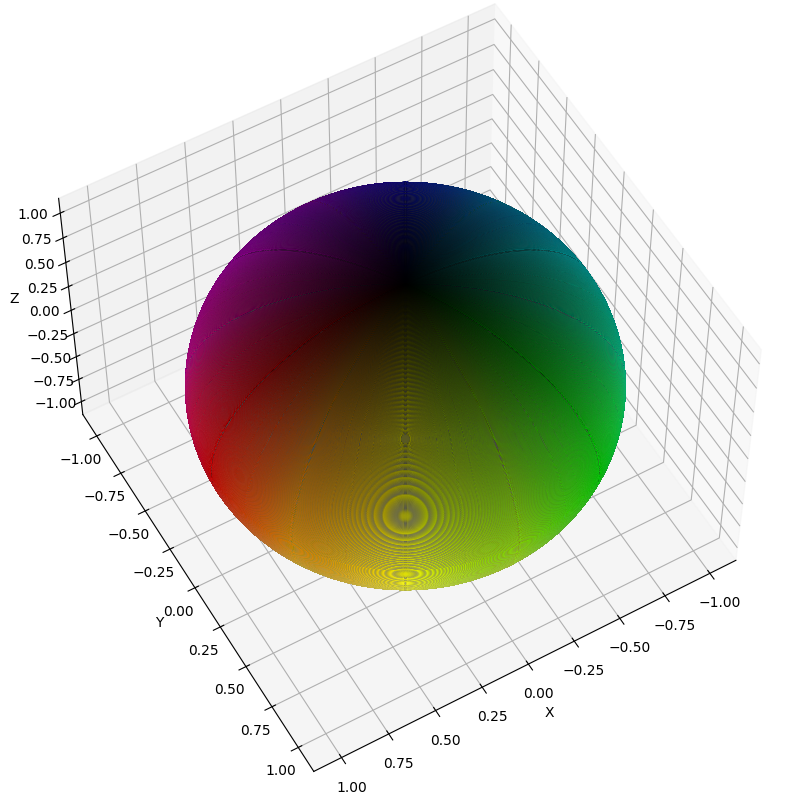

In [30]:
import numpy as np
import matplotlib.pyplot as plt

class RGBMapping3D:
    def __init__(self, color_coord, color_list):
        self.color_coord = color_coord
        self.color_list = color_list

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        colors = self.color_list / 255.0  # Normalize color values

        ax.scatter(self.color_coord[:, 0], self.color_coord[:, 1], self.color_coord[:, 2], c=colors, marker='o')
        ax.view_init(55, 60)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        plt.show()

# 가정: color_coord_unique와 color_list_unique는 이미 NumPy 배열입니다
rgb_mapping_3d = RGBMapping3D(color_coord_unique, color_list_unique)

# Plot coordinates
rgb_mapping_3d.plot_points()

In [34]:
color_list_unique[1]

array([0, 0, 1], dtype=uint8)

In [35]:
color_angle_unique[1]

array([3.0799927e-03, 4.1887903e+00], dtype=float32)

In [36]:
color_coord_unique[1]

array([-0.00153999, -0.00266735,  0.99999523], dtype=float32)

# Region of Point

In [109]:
color_list_unique

array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [255, 255, 253],
       [255, 255, 254],
       [255, 255, 255]], dtype=uint8)

In [110]:
total_rgb = 16777216

theta_lower = np.zeros((total_rgb), dtype=np.float32)
theta_upper = np.zeros((total_rgb), dtype=np.float32)
phi_lower = np.zeros((total_rgb), dtype=np.float32)
phi_upper = np.zeros((total_rgb), dtype=np.float32)


for i, color in enumerate(color_list_unique):
    r,g,b = color
    m = max(r,g,b) # m
    n = min(r,g,b)
    sum = m+n
    sub = m-n
    theta, phi = color_angle_unique[i]
    if m ==0: # Formula 1
        theta_lower[i] = 0
        theta_upper[i] = np.pi/2040-(1e-10)
        phi_lower[i] = 0
        phi_upper[i] = 2*np.pi-(1e-10)

    elif sum <255 and n == int(np.floor(sum/2)) and m==n: # Formula 3-2
        theta_lower[i] = theta - np.pi/1020/int(np.floor((sum-1)/2)+1)
        theta_upper[i] = theta + np.pi/1020/int(np.floor((sum)/2)+1)- (1e-10)
        phi_lower[i] = 0
        phi_upper[i] = 2*np.pi - (1e-10)

    elif sum <255 and n == int(np.floor(sum/2)): # Formula 3-1
        theta_lower[i] = theta - np.pi/1020/int(np.floor((sum-1)/2)+1)
        theta_upper[i] = theta + np.pi/1020/int(np.floor((sum)/2)+1)- (1e-10)
        phi_lower[i] = phi - np.pi/6/sub
        phi_upper[i] = phi + np.pi/6/sub - (1e-10)

    elif sum <255: # Formula 2
        delta = np.pi/1020/int(np.floor(sum/2)+1)
        theta_lower[i] = theta - delta
        theta_upper[i] = theta + delta - (1e-10)
        phi_lower[i] = phi - np.pi/6/sub
        phi_upper[i] = phi + np.pi/6/sub - (1e-10)

    elif m == 255 and n ==0: # Formula 4
        theta_lower[i] = np.pi/2-np.pi/1020/126
        theta_upper[i] = np.pi/2+np.pi/1020/128
        phi_lower[i] = phi - np.pi/6/255
        phi_upper[i] = phi + np.pi/6/255 - (1e-10)

    elif sum == 255 and n % 2 == 1 and 1 <= n <= 127: # Formula 5
        delta = np.pi/1020/128
        theta_lower[i] = theta - delta
        theta_upper[i] = theta + delta - (1e-10)
        phi_lower[i] = phi - np.pi/6/sub
        phi_upper[i] = phi + np.pi/6/sub

    elif sum == 255 and n % 2 == 0 and 1 <= n <= 124: # Formula 6-1
        delta = np.pi/1020/126
        theta_lower[i] = theta - delta - (1e-10)
        theta_upper[i] = theta + delta 
        phi_lower[i] = phi - np.pi/6/sub
        phi_upper[i] = phi + np.pi/6/sub - (1e-10)

    elif sum == 255 and n == 126: # Formula 6-2
        theta_lower[i] = theta - np.pi/1020/126 - (1e-10)
        theta_upper[i] = theta + np.pi/1020/128
        phi_lower[i] = phi - np.pi/6/sub
        phi_upper[i] = phi + np.pi/6/sub - (1e-10)

    elif sum > 255: 
        a = sum-255
        if n == int(np.floor((255-a)/2)) and m==n: # Formula 8-2
            theta_lower[i] = theta - np.pi/1020/(int(np.floor((255-a)/2))+1) - (1e-10)
            theta_upper[i] = theta + np.pi/1020/(int(np.floor((255-a-1)/2))+1) 
            phi_lower[i] = 0
            phi_upper[i] = 2*np.pi- (1e-10)

        elif n == int(np.floor((255-a)/2)): # Formula 8-1
            theta_lower[i] = theta - np.pi/1020/(int(np.floor((255-a)/2))+1) - (1e-10)
            theta_upper[i] = theta + np.pi/1020/(int(np.floor((255-a-1)/2))+1) 
            phi_lower[i] = phi - np.pi/6/sub
            phi_upper[i] = phi + np.pi/6/sub - (1e-10)
        
        else: # Formula 7
            delta = np.pi/1020/(np.floor((255-a)/2)+1)
            theta_lower[i] = theta - delta - (1e-10)
            theta_upper[i] = theta + delta
            phi_lower[i] = phi - np.pi/6/sub
            phi_upper[i] = phi + np.pi/6/sub -(1e-10)

    elif m ==255 and n ==255: # Formula 9
        theta_lower[i] = 2039*np.pi/2040- (1e-10)
        theta_upper[i] = np.pi
        phi_lower[i] = 0
        phi_upper[i] = 2 * np.pi -(1e-10)


C:\Users\HCI\AppData\Local\Temp\ipykernel_5076\3929926936.py:13: RuntimeWarning: overflow encountered in scalar add
  sum = m+n
C:\Users\HCI\AppData\Local\Temp\ipykernel_5076\3929926936.py:38: RuntimeWarning: divide by zero encountered in divide
  phi_lower[i] = phi - np.pi/6/sub
C:\Users\HCI\AppData\Local\Temp\ipykernel_5076\3929926936.py:39: RuntimeWarning: divide by zero encountered in divide
  phi_upper[i] = phi + np.pi/6/sub - (1e-10)


In [111]:
theta = color_angle_unique[:, 0]
phi = color_angle_unique[:, 1]
theta_range = theta_upper - theta_lower
phi_range = phi_upper - phi_lower

In [112]:
import pandas as pd

for i in range(32):
    index = index = [f"[{rgb[0]}, {rgb[1]}, {rgb[2]}]" for rgb in color_list_unique[524288*i:524288*(i+1)]]
    # RGB 값과 theta, phi 값을 결합하여 딕셔너리 생성
    # 데이터프레임 생성
    df = pd.DataFrame({
        "theta": theta[524288*i:524288*(i+1)],
        "phi": phi[524288*i:524288*(i+1)],
        'theta_lower': theta_lower[524288*i:524288*(i+1)],
        'theta_upper': theta_upper[524288*i:524288*(i+1)],
        'phi_lower': phi_lower[524288*i:524288*(i+1)],
        'phi_upper': phi_upper[524288*i:524288*(i+1)],
        'theta range' : theta_range[524288*i:524288*(i+1)],
        'phi range' : phi_range[524288*i:524288*(i+1)]
    }, index=index)

    # 인덱스 이름 설정 (선택 사항)
    df.index.name = "RGB"
    df.to_excel(f"new color_space_angle{i*8}.xlsx")  # 파일 이름 지정

In [14]:
import pandas as pd

df = pd.read_excel('color_space_angle0.xlsx')
# 특정 인덱스 (예: first_index)를 사용하여 해당 theta 값을 가져오기
target_theta = df.loc[2, 'theta']
print(target_theta)
# 1. target_theta보다 작은 값 중에서 가장 큰 theta 값 (바로 이전 값)
previous_theta = df[df['theta'] < target_theta]['theta'].max()

# 2. target_theta보다 큰 값 중에서 가장 작은 theta 값 (바로 다음 값)
next_theta = df[df['theta'] > target_theta]['theta'].min()

# 결과 출력
print(f"기준 theta 값: {target_theta}")
print(f"바로 이전 theta 값: {previous_theta}")
print(f"바로 다음 theta 값: {next_theta}")


0.01231997119054821
기준 theta 값: 0.01231997119054821
바로 이전 theta 값: 0.009239978392911156
바로 다음 theta 값: 0.01539996398818526


In [19]:
color_coord_np = np.array([point[0] for point in color_coord])
color_list_np = np.array([point[0] for point in color_list])
color_angle_np = np.array([point for point in color_angle])

_, unique_indices = np.unique(color_list_np, axis=0, return_index=True)
# color_list_np와 color_angle_np에서 중복을 제거합니다.
color_list_unique = color_list_np[unique_indices]
color_angle_unique = color_angle_np[unique_indices]
color_coord_unique = color_coord_np[unique_indices]

# 리스트 형식으로 변환
unique_color_list = color_list_unique.tolist()
unique_color_angle = color_angle_unique.tolist()
unique_color_coord = color_coord_unique.tolist()


MemoryError: Unable to allocate 640. MiB for an array with shape (41942396, 2) and data type float64

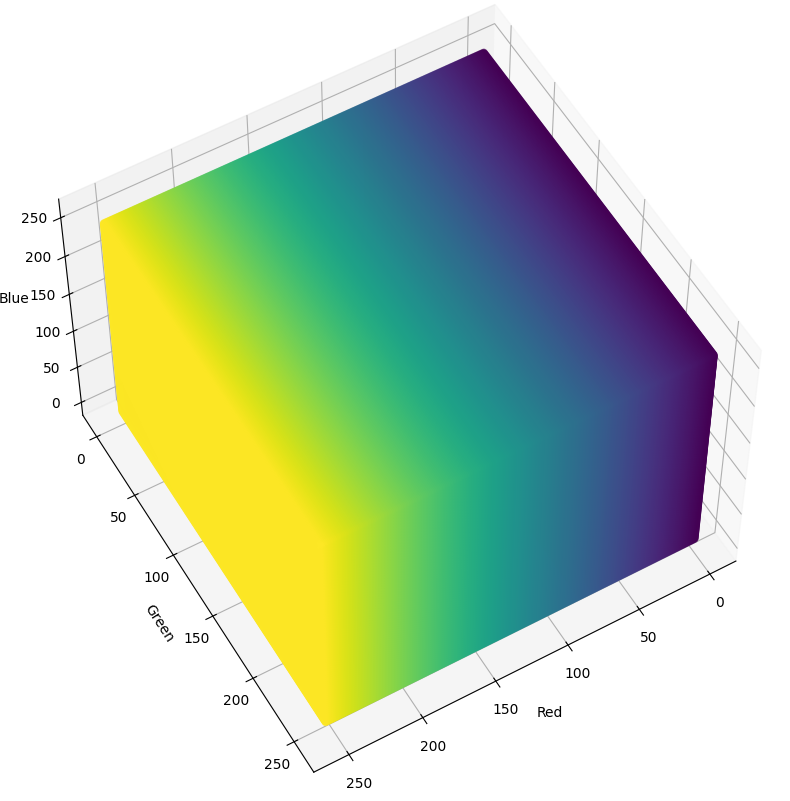

In [ ]:
class RGBMapping3D:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        points = self.color_list
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(55, 60)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

rgb_mapping_3d = RGBMapping3D(color_coord_unique, color_list_unique)

# Plot coordinates
rgb_mapping_3d.plot_points()

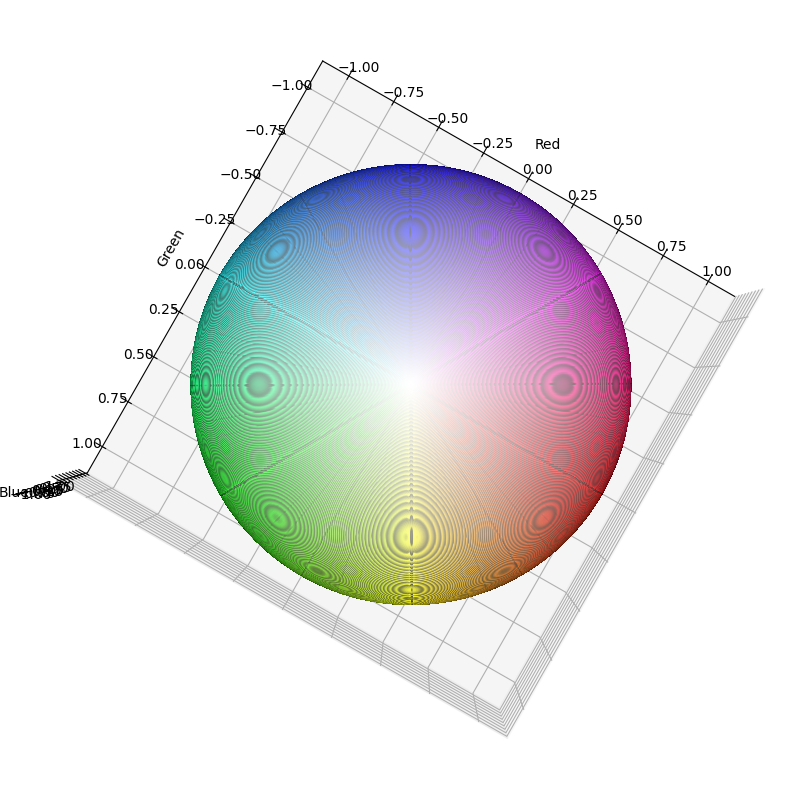

Thus, 16777216


In [33]:
class RGBMapping3DS:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB values to coordinates
        points = self.color_list
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(270, 60)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

rgb_mapping_3d_south = RGBMapping3DS(color_index_unique, color_list_unique)

# Plot coordinates
rgb_mapping_3d_south.plot_points()
print("Thus,", len(color_index_unique))

In [47]:
class RGBMapping3D_side:
    def __init__(self, color_index, color_list):
        self.color_index = np.array(color_index)
        self.color_list = np.array(color_list)

    def plot_points(self):
        fig = plt.figure(figsize=(14,10))
        ax = fig.add_subplot(111, projection='3d')

        # RGB 값에 해당하는 좌표를 점으로 플로팅
        points = self.color_list
        colors = self.color_index / 255

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')
        ax.view_init(0,270)
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

        plt.show()

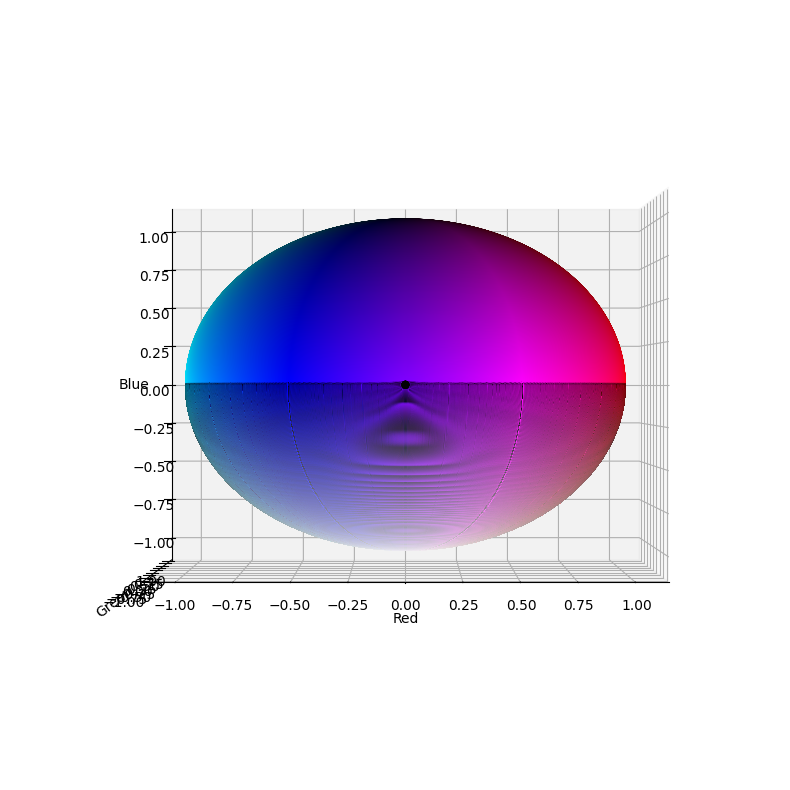

In [48]:
rgb_mapping_3d_side = RGBMapping3D_side(color_index_unique, color_list_unique)

# Plot coordinates
rgb_mapping_3d_side.plot_points()

위 그림과 같이 Bloch Sphere로 표현된 RGB 값의 좌표를 회로에 설계하여 측정한 다음,
State의 coefficient를 사용하여 계산하면 원래 RGB 값을 추론할 수 있다

또한 Look-Up-Table을 통해 해당 x,y,z 값을 갖는 RGB 값을 찾아보면 처음에 매핑한 RGB 값을 찾을 수 있다.

# Example

#### RGB = [200,100,0]

In [182]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)
'''
recon_color_index = recon_color[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = recon_color_index / 255
ax.scatter(1,1,c=colors, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
'''

C:\Users\HCI\AppData\Local\Temp\ipykernel_10404\836800596.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


0.32959 s
[array([200.53888542, 101.84763116,   0.        ])]


"\nrecon_color_index = recon_color[0]\nfig = plt.figure()\nax = fig.add_subplot(111)\ncolors = recon_color_index / 255\nax.scatter(1,1,c=colors, marker='o')\nax.set_xlabel('Red')\nax.set_ylabel('Green')\n"

In [183]:
counts

{'10': 90888, '00': 98106, '11': 9251, '01': 1755}

In [184]:
counts_qiskit = {'|10>': 90888/200000, '|00>': 98106/200000, '|11>': 9251/200000, '|01>': 1755/200000}

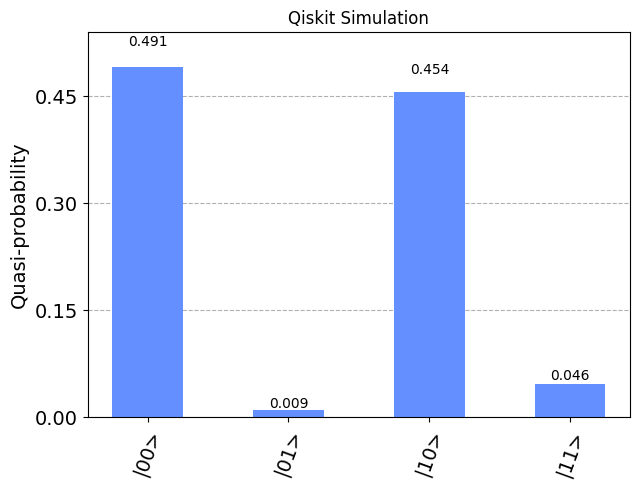

In [185]:
plot_histogram(counts_qiskit,title="Qiskit Simulation")

In [160]:
n = 200
k = 100
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi_origin = round(np.arctan2(y,x),4) / 2
theta_origin = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

phi_err = []
theta_err = []
total_err = []
recon_color_list = []
recon_color_err = []
delta_color = []
for iter in range(21):
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=10000*(iter+10))
    job = aer_sim.run(qobj)
    result = job.result()
    counts = result.get_counts()
    pixel_color_theta_recon = []
    pixel_color_phi_recon = []

    pixel_color_theta = []
    pixel_color_phi = []

    for i in range(0, 1):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[-1]
            decision = int(key[0])
            bin_coord = key[1:-1]

            if decision == 1:
                pixel_color_theta.append((state, amount))
            elif decision == 0:
                pixel_color_phi.append((state, amount))

    # ======================== phi ====================================
    total_phi_value = 0
    for state in pixel_color_phi:
        state_value = state[1]
        total_phi_value += state_value

    phi_state_0 = []
    for phi, amount in pixel_color_phi:
        if not int(phi):
            phi_state_0.append((phi, amount))

    for i in range(1):
        try:
            phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
            pixel_color_phi_recon.append(phi*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================

    total_theta_value = 0
    for state in pixel_color_theta:
        state_value = state[1]
        total_theta_value += state_value

    theta_state_0 = []
    for theta, amount in pixel_color_theta:
        if not int(theta):
            theta_state_0.append((theta, amount))

    for i in range(1):
        try:
            theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
            pixel_color_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_color = []
    for i in range(len(pixel_color_phi_recon)):
        n_recon = round(pixel_color_theta_recon[i] * 1020 / np.pi,5)
        k_recon = round(pixel_color_phi_recon[i] * 6 * n_recon / np.pi,5)

        if phi <= 0.5236:
            recon_color.append(np.array([n_recon,k_recon,0]))
        ''''
        elif 0.5236 < phi <= 0.5236*2:
            recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
        elif 0.5236*2 < phi <= 0.5236*3:
            recon_color.append(np.array([0,n_recon,k_recon]))
        elif 0.5236*3 < phi <= 0.5236*4:
            recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
        elif 0.5236*4 < phi <= 0.5236*5:
            recon_color.append(np.array([k_recon,0,n_recon]))
        elif 0.5236*5 < phi <= 0.5236*6:
            recon_color.append(np.array([n_recon,0,n_recon-k_recon]))
        '''

    print("iteration = ",(iter+10)*100000)
    print("phi_recon = ",pixel_color_phi_recon[0])
    print("theta_recon = ",pixel_color_theta_recon[0])

    phi_err.append(abs(pixel_color_phi_recon[0]-phi_origin))
    
    theta_err.append(abs(pixel_color_theta_recon[0]-theta_origin))
    total_err.append(abs(pixel_color_phi_recon[0]-phi_origin) + abs(pixel_color_theta_recon[0]-theta_origin))
    recon_color_list.append(recon_color)
    recon_color_err.append(abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    delta_color.append([round(list(recon_color[0])[0]-200,5),round(list(recon_color[0])[1]-100,5),0])
    print("Reconstructed color = ",recon_color)
    print("Delta Color r= ",delta_color)
    print("Color Error = ",abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    print("==========================================================================")

print("phi_err = ", phi_err)
print("theta_err = ",theta_err)

C:\Users\HCI\AppData\Local\Temp\ipykernel_10404\177678720.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


iteration =  1000000
phi_recon =  0.2665764539645747
theta_recon =  0.6176704281395938
Reconstructed color =  [array([200.54282, 102.10107,   0.     ])]
Delta Color r=  [[0.54282, 2.10107, 0]]
Color Error =  2.643890000000013
iteration =  1100000
phi_recon =  0.2557712729361898
theta_recon =  0.6102533281915612
Reconstructed color =  [array([198.13466,  96.78624,   0.     ])]
Delta Color r=  [[0.54282, 2.10107, 0], [-1.86534, -3.21376, 0]]
Color Error =  5.079099999999997
iteration =  1200000
phi_recon =  0.25943795430249283
theta_recon =  0.6159741833395848
Reconstructed color =  [array([199.99209,  99.09408,   0.     ])]
Delta Color r=  [[0.54282, 2.10107, 0], [-1.86534, -3.21376, 0], [-0.00791, -0.90592, 0]]
Color Error =  0.9138300000000044
iteration =  1300000
phi_recon =  0.2615826478198346
theta_recon =  0.6158933712281086
Reconstructed color =  [array([199.96585,  99.90015,   0.     ])]
Delta Color r=  [[0.54282, 2.10107, 0], [-1.86534, -3.21376, 0], [-0.00791, -0.90592, 0], [-

In [161]:
import pandas as pd

df = pd.DataFrame({"Iterations" : iters,
"Error of $\phi$" : phi_err,
"Error of $\\theta$" : theta_err,
"Error Sum" : total_err,
"Recon color" : recon_color_list,
"Delta color" : delta_color,
"Color Error":recon_color_err})
df

Iterations  Error of $\phi$  Error of $\theta$  Error Sum  \
0       100000         0.004776           0.001670   0.006447   
1       110000         0.006029           0.005747   0.011775   
2       120000         0.002362           0.000026   0.002388   
3       130000         0.000217           0.000107   0.000324   
4       140000         0.006515           0.005194   0.011709   
5       150000         0.000628           0.011525   0.012152   
6       160000         0.001677           0.007935   0.009613   
7       170000         0.001735           0.002744   0.004479   
8       180000         0.002286           0.006447   0.008734   
9       190000         0.001957           0.001954   0.003912   
10      200000         0.004194           0.000395   0.004589   
11      210000         0.000021           0.002909   0.002930   
12      220000         0.004486           0.001791   0.006277   
13      230000         0.000796           0.000954   0.001750   
14      240000         0.002370           0.005713   0.008084   
15      250000         0.001174           0.000751   0.001925   
16      260000         0.000468           0.001386   0.001854   
17      270000         0.002219           0.004172   0.006391   
18      280000         0.001645           0.002663   0.004309   
19      290000         0.001011           0.001177   0.002188   
20      300000         0.004231           0.000747   0.004978   

                      Recon color              Delta color  Color Error  
0   [[200.54282, 102.10107, 0.0]]    [0.54282, 2.10107, 0]      2.64389  
1    [[198.13466, 96.78624, 0.0]]  [-1.86534, -3.21376, 0]      5.07910  
2    [[199.99209, 99.09408, 0.0]]  [-0.00791, -0.90592, 0]      0.91383  
3    [[199.96585, 99.90015, 0.0]]  [-0.03415, -0.09985, 0]      0.13400  
4    [[198.31416, 96.68959, 0.0]]  [-1.68584, -3.31041, 0]      4.99625  
5   [[203.74229, 102.11559, 0.0]]    [3.74229, 2.11559, 0]      5.85788  
6    [[197.42404, 98.07985, 0.0]]  [-2.57596, -1.92015, 0]      4.49611  
7    [[199.10971, 98.89529, 0.0]]  [-0.89029, -1.10471, 0]      1.99500  
8   [[202.09371, 100.16457, 0.0]]    [2.09371, 0.16457, 0]      2.25828  
9    [[200.63497, 99.56771, 0.0]]   [0.63497, -0.43229, 0]      1.06726  
10   [[200.12879, 98.46166, 0.0]]   [0.12879, -1.53834, 0]      1.66713  
11    [[199.05604, 99.5364, 0.0]]   [-0.94396, -0.4636, 0]      1.40756  
12   [[200.5819, 102.00966, 0.0]]     [0.5819, 2.00966, 0]      2.59156  
13   [[199.69073, 99.54202, 0.0]]  [-0.30927, -0.45798, 0]      0.76725  
14   [[198.14547, 99.96998, 0.0]]  [-1.85453, -0.03002, 0]      1.88455  
15    [[199.75673, 99.4307, 0.0]]   [-0.24327, -0.5693, 0]      0.81257  
16  [[200.45056, 100.40461, 0.0]]    [0.45056, 0.40461, 0]      0.85517  
17    [[198.64588, 100.165, 0.0]]     [-1.35412, 0.165, 0]      1.51912  
18  [[200.86519, 101.06399, 0.0]]    [0.86519, 1.06399, 0]      1.92918  
19  [[199.61845, 100.19496, 0.0]]   [-0.38155, 0.19496, 0]      0.57651  
20   [[199.75799, 98.26496, 0.0]]  [-0.24201, -1.73504, 0]      1.97705

In [163]:
df.to_excel("qiskit simulation.xlsx", index=False)

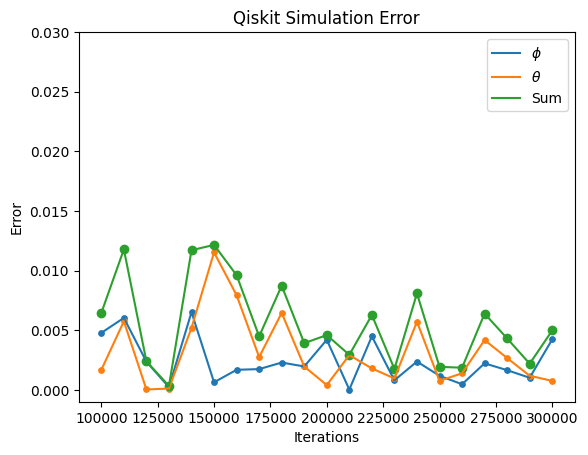

In [164]:
iters = []
for iter in range(21):
    iters.append((iter+10)*10000)

plt.title("Qiskit Simulation Error")
plt.scatter(iters,phi_err,s=15)
plt.scatter(iters,theta_err,s=15)
plt.scatter(iters,total_err, s = 36)
plt.plot(iters,phi_err, label = "$\phi$")
plt.plot(iters,theta_err, label="$\\theta$")
plt.plot(iters,total_err, label = "Sum")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(-0.001,0.03)
plt.legend()
plt.show()


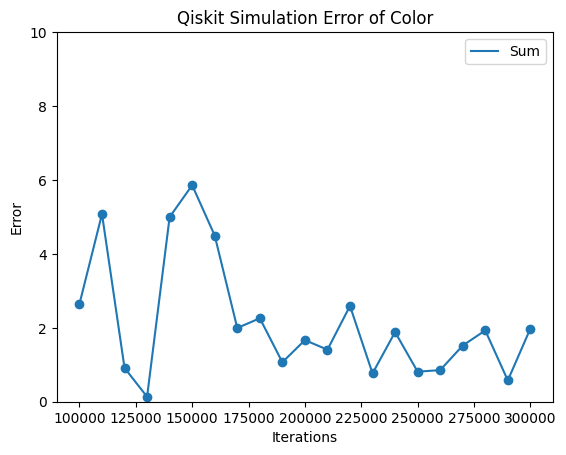

In [165]:
plt.title("Qiskit Simulation Error of Color")
plt.scatter(iters,recon_color_err, s = 36)
plt.plot(iters,recon_color_err, label = "Sum")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(0,10)
plt.legend()
plt.show()

In [173]:
n = 200
k = 100
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi_origin = round(np.arctan2(y,x),4) / 2
theta_origin = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi_origin,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

phi_err = []
theta_err = []
total_err = []
recon_color_list = []
recon_color_err = []
delta_color = []
for iter in range(21):
    ionq_sim = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc, ionq_sim)
    job_ionq = ionq_sim.run(t_qc_image, shots=10000*(iter+10))
    result_ionq = job_ionq.result()
    counts = result_ionq.get_counts()

    pixel_color_theta_recon = []
    pixel_color_phi_recon = []

    pixel_color_theta = []
    pixel_color_phi = []

    for i in range(0, 1):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[-1]
            decision = int(key[0])
            bin_coord = key[1:-1]

            if decision == 1:
                pixel_color_theta.append((state, amount))
            elif decision == 0:
                pixel_color_phi.append((state, amount))

    # ======================== phi ====================================
    total_phi_value = 0
    for state in pixel_color_phi:
        state_value = state[1]
        total_phi_value += state_value

    phi_state_0 = []
    for phi, amount in pixel_color_phi:
        if not int(phi):
            phi_state_0.append((phi, amount))

    for i in range(1):
        try:
            phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
            pixel_color_phi_recon.append(phi*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    # ======================== theta ====================================

    total_theta_value = 0
    for state in pixel_color_theta:
        state_value = state[1]
        total_theta_value += state_value

    theta_state_0 = []
    for theta, amount in pixel_color_theta:
        if not int(theta):
            theta_state_0.append((theta, amount))

    for i in range(1):
        try:
            theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
            pixel_color_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")

    recon_color = []
    for i in range(len(pixel_color_phi_recon)):
        n_recon = round(pixel_color_theta_recon[i] * 1020 / np.pi,5)
        k_recon = round(pixel_color_phi_recon[i] * 6 * n_recon / np.pi,5)

        if phi <= 0.5236:
            recon_color.append(np.array([n_recon,k_recon,0]))
        ''''
        elif 0.5236 < phi <= 0.5236*2:
            recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
        elif 0.5236*2 < phi <= 0.5236*3:
            recon_color.append(np.array([0,n_recon,k_recon]))
        elif 0.5236*3 < phi <= 0.5236*4:
            recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
        elif 0.5236*4 < phi <= 0.5236*5:
            recon_color.append(np.array([k_recon,0,n_recon]))
        elif 0.5236*5 < phi <= 0.5236*6:
            recon_color.append(np.array([n_recon,0,n_recon-k_recon]))
        '''

    print("iteration = ",(iter+10)*10000)
    print("phi_recon = ",pixel_color_phi_recon[0])
    print("theta_recon = ",pixel_color_theta_recon[0])

    phi_err.append(abs(pixel_color_phi_recon[0]-phi_origin))
    theta_err.append(abs(pixel_color_theta_recon[0]-theta_origin))
    total_err.append(abs(pixel_color_phi_recon[0]-phi_origin) + abs(pixel_color_theta_recon[0]-theta_origin))
    recon_color_list.append(recon_color)
    recon_color_err.append(abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    delta_color.append([round(list(recon_color[0])[0]-200,5),round(list(recon_color[0])[1]-100,5),0])
    print("Reconstructed color = ",recon_color)

    print("Color Error = ",abs(list(recon_color[0])[0]-200)+abs(list(recon_color[0])[1]-100))
    print("==========================================================================")
print("Delta Color r= ",delta_color)
print("phi_err = ", phi_err)
print("theta_err = ",theta_err)

iteration =  100000
phi_recon =  0.25599090069061686
theta_recon =  0.620231908126093
Reconstructed color =  [array([201.37447,  98.45331,   0.     ])]
Color Error =  2.9211600000000004
iteration =  110000
phi_recon =  0.26310984546185323
theta_recon =  0.6121191936339979
Reconstructed color =  [array([198.74046,  99.86764,   0.     ])]
Color Error =  1.3918999999999926
iteration =  120000
phi_recon =  0.2596014693752737
theta_recon =  0.6157176042861424
Reconstructed color =  [array([199.90878,  99.11523,   0.     ])]
Color Error =  0.9759899999999959
iteration =  130000
phi_recon =  0.2599299246170277
theta_recon =  0.6188342313190427
Reconstructed color =  [array([200.92067,  99.74297,   0.     ])]
Color Error =  1.1777000000000015
iteration =  140000
phi_recon =  0.2595285545557457
theta_recon =  0.6096235582051347
Reconstructed color =  [array([197.93019,  98.10668,   0.     ])]
Color Error =  3.9631299999999925
iteration =  150000
phi_recon =  0.260980363845207
theta_recon =  0.6

In [174]:
df = pd.DataFrame({"Iterations" : iters,
"Error of $\phi$" : phi_err,
"Error of $\\theta$" : theta_err,
"Error Sum" : total_err,
"Recon color" : recon_color_list,
"Delta color" : delta_color,
"Color Error":recon_color_err})
df

Iterations  Error of $\phi$  Error of $\theta$  Error Sum  \
0       100000         0.005809           0.004232   0.010041   
1       110000         0.001310           0.003881   0.005191   
2       120000         0.002199           0.000282   0.002481   
3       130000         0.001870           0.002834   0.004704   
4       140000         0.002271           0.006376   0.008648   
5       150000         0.000820           0.001018   0.001837   
6       160000         0.001616           0.003313   0.004929   
7       170000         0.003307           0.001524   0.004831   
8       180000         0.001086           0.002118   0.003204   
9       190000         0.001568           0.004723   0.006290   
10      200000         0.001110           0.001609   0.002719   
11      210000         0.001868           0.000753   0.002621   
12      220000         0.006697           0.002126   0.008822   
13      230000         0.003167           0.000964   0.004131   
14      240000         0.001789           0.001396   0.003185   
15      250000         0.002943           0.003596   0.006539   
16      260000         0.002188           0.001131   0.003319   
17      270000         0.001215           0.000235   0.001450   
18      280000         0.004245           0.002502   0.006747   
19      290000         0.001370           0.001292   0.002662   
20      300000         0.002153           0.002878   0.005031   

                      Recon color              Delta color  Color Error  
0    [[201.37447, 98.45331, 0.0]]   [1.37447, -1.54669, 0]      2.92116  
1    [[198.74046, 99.86764, 0.0]]  [-1.25954, -0.13236, 0]      1.39190  
2    [[199.90878, 99.11523, 0.0]]  [-0.09122, -0.88477, 0]      0.97599  
3    [[200.92067, 99.74297, 0.0]]   [0.92067, -0.25703, 0]      1.17770  
4    [[197.93019, 98.10668, 0.0]]  [-2.06981, -1.89332, 0]      3.96313  
5       [[199.67, 99.52267, 0.0]]     [-0.33, -0.47733, 0]      0.80733  
6    [[201.07609, 99.91768, 0.0]]   [1.07609, -0.08232, 0]      1.15841  
7   [[199.50561, 101.01294, 0.0]]   [-0.49439, 1.01294, 0]      1.50733  
8   [[199.31266, 100.06982, 0.0]]   [-0.68734, 0.06982, 0]      0.75716  
9   [[201.53376, 100.16368, 0.0]]    [1.53376, 0.16368, 0]      1.69744  
10  [[199.47793, 100.16196, 0.0]]   [-0.52207, 0.16196, 0]      0.68403  
11   [[200.24507, 99.40837, 0.0]]   [0.24507, -0.59163, 0]      0.83670  
12   [[200.69062, 97.77874, 0.0]]   [0.69062, -2.22126, 0]      2.91188  
13    [[200.3133, 98.94526, 0.0]]    [0.3133, -1.05474, 0]      1.36804  
14   [[200.45385, 99.54232, 0.0]]   [0.45385, -0.45768, 0]      0.91153  
15  [[201.16786, 101.71491, 0.0]]    [1.16786, 1.71491, 0]      2.88277  
16  [[200.36762, 101.02146, 0.0]]    [0.36762, 1.02146, 0]      1.38908  
17   [[199.92409, 99.49854, 0.0]]  [-0.07591, -0.50146, 0]      0.57737  
18   [[200.81271, 98.77843, 0.0]]   [0.81271, -1.22157, 0]      2.03428  
19   [[200.41984, 99.68564, 0.0]]   [0.41984, -0.31436, 0]      0.73420  
20   [[200.93502, 99.64151, 0.0]]   [0.93502, -0.35849, 0]      1.29351

In [175]:
df.to_excel("IonQ simulation.xlsx", index=False)

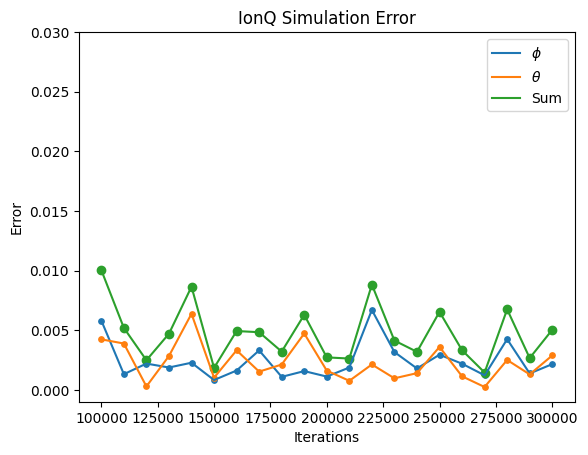

In [176]:
iters = []
for iter in range(21):
    iters.append((iter+10)*10000)

plt.title("IonQ Simulation Error")
plt.scatter(iters,phi_err,s=15)
plt.scatter(iters,theta_err,s=15)
plt.scatter(iters,total_err, s = 36)
plt.plot(iters,phi_err, label = "$\phi$")
plt.plot(iters,theta_err, label="$\\theta$")
plt.plot(iters,total_err, label = "Sum")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(-0.001,0.03)
plt.legend()
plt.show()

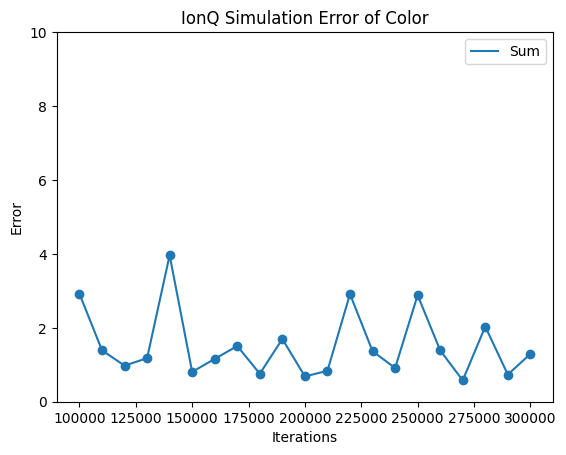

In [177]:
plt.title("IonQ Simulation Error of Color")
plt.scatter(iters,recon_color_err, s = 36)
plt.plot(iters,recon_color_err, label = "Sum")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.ylim(0,10)
plt.legend()
plt.show()

In [31]:
counts.items()

dict_items([('10', 90695), ('00', 98419), ('11', 9155), ('01', 1731)])

In [19]:
counts_simul_prob = {'|11>': 9155/200000, '|10>': 90695/200000, '|00>': 98419/200000, '|01>': 1731/200000}

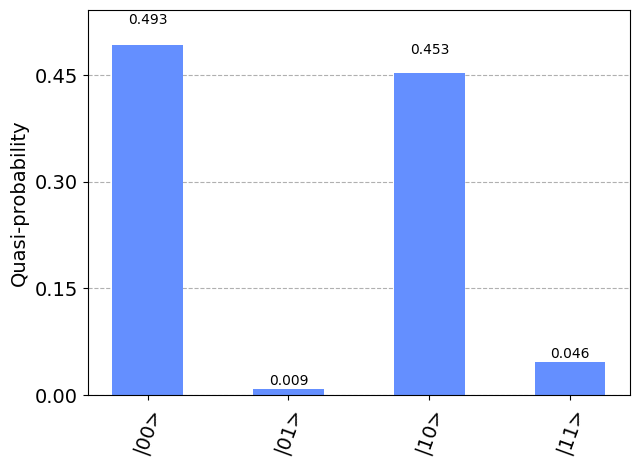

In [20]:
plot_histogram(counts_simul_prob)

In [45]:
error = []
for i in range(1):
    del_x = recon_color[0][0] - n
    del_y = recon_color[0][1] - k
    err = np.sqrt(del_x**2+del_y**2)
    error.append(err)

print("error = ",error,"time = ", time_simul)

error =  [3.1722207109397123] time =  0.380831241607666


In [3]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

In [186]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=200000)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)


9.96154 s
[array([198.88393341,  99.8807277 ,   0.        ])]


In [187]:
counts

{'00': 98585, '01': 1724, '10': 90628, '11': 9063}

In [188]:
counts_simul = {'|00>': 98585/200000, '|01>': 1724/200000, '|10>': 90628/200000, '|11>': 9063/200000}

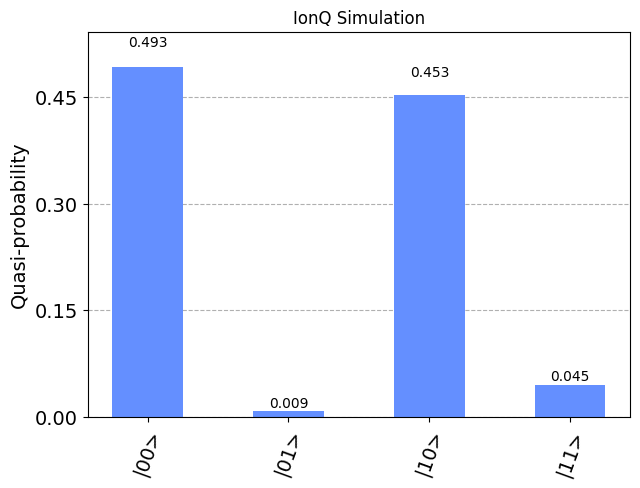

In [189]:
plot_histogram(counts_simul, title ="IonQ Simulation")

In [254]:
counts_ = {'|00>': 0.49177, '|01>': 0.0826, '|10>': 0.45429, '|11>': 0.04568}

{'00': 49177, '01': 826, '10': 45429, '11': 4568}

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\2898810973.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors, marker='o')


Text(0, 0.5, 'Green')

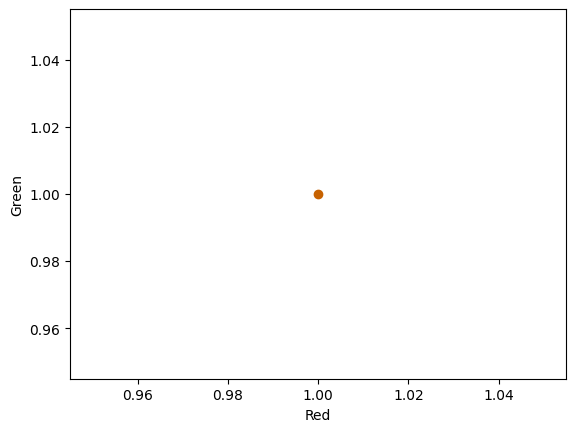

In [253]:
recon_color_index = recon_color[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors = recon_color_index / 255
ax.scatter(1,1,c=colors, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [255]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job = ionq_sim.run(t_qc_image, shots=200000)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)


8.62378 s
[array([198.84198457,  98.8291607 ,   0.        ])]


In [268]:
counts_re = {'|00>': 0.97931, '|01>': 0.01677, '|10>': 0.91269, '|11>': 0.09123}

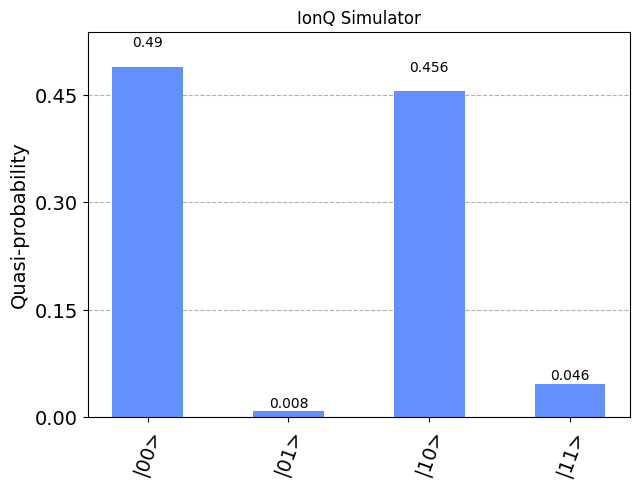

In [276]:
plot_histogram(counts_re, title ="IonQ Simulator")

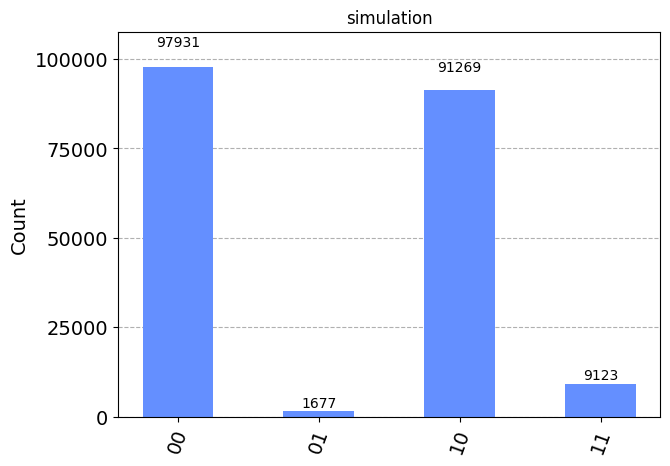

In [257]:
plot_histogram(counts, title ="simulation")

In [225]:
ionq_result={"|00>":0.4816,"|01>":0.0178,"|10>":0.4438,"|11>":0.0568}

In [224]:
counts_renew = {'|00>': 0.98150, '|01>': 0.1758, '|10>': 0.90728, '|11>': 0.09364}

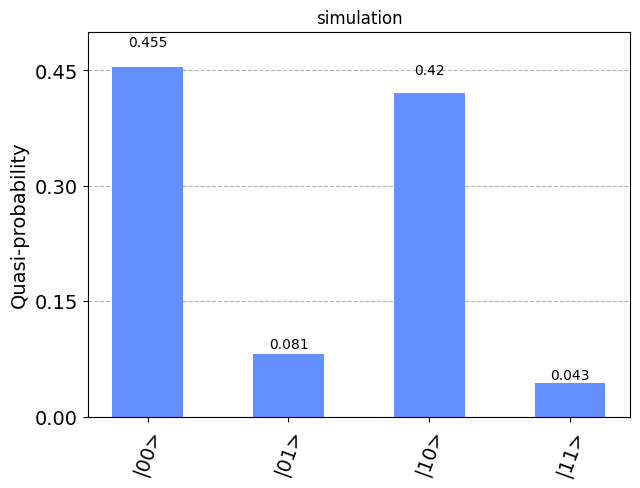

In [239]:
plot_histogram(counts_renew, title ="simulation",)

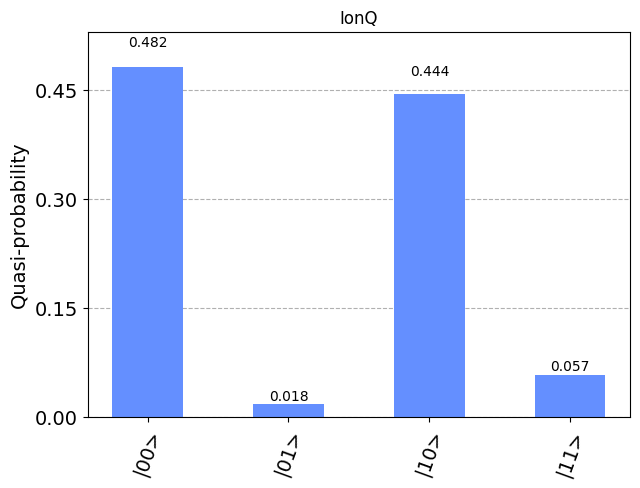

In [248]:
plot_histogram(ionq_result, title ="IonQ",)

In [249]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
print(theta)
print(phi)

0.616
0.2618


In [270]:
n = 200
k = 100

start = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(phi):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        phi = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(phi*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color = []
for i in range(len(pixel_color_phi_recon)):
    n_recon = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon = pixel_color_phi_recon[i] * 6 * n_recon / np.pi
    if phi <= 0.5236:
        recon_color.append(np.array([n_recon,k_recon,0]))
    elif 0.5236 < phi <= 0.5236*2:
        recon_color.append(np.array([n_recon-k_recon,n_recon,0]))
    elif 0.5236*2 < phi <= 0.5236*3:
        recon_color.append(np.array([0,n_recon,k_recon]))
    elif 0.5236*3 < phi <= 0.5236*4:
        recon_color.append(np.array([0,n_recon-k_recon,n_recon]))
    elif 0.5236*4 < phi <= 0.5236*5:
        recon_color.append(np.array([k_recon,0,n_recon]))
    elif 0.5236*5 < phi <= 0.5236*6:
        recon_color.append(np.array([n_recon,0,n_recon-k_recon]))



end = time.time()
time_simul = end - start
print(f'{time_simul:.5f}', "s")
print(recon_color)


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\3034943071.py:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


0.73403 s
[array([199.92496796,  99.52428075,   0.        ])]


In [272]:
counts

{'00': 98434, '10': 90703, '11': 9172, '01': 1691}

In [274]:
counts_aer = {'|00>': 0.98434, '|10>': 0.90703, '|11>': 0.09172, '|01>': 0.01691}

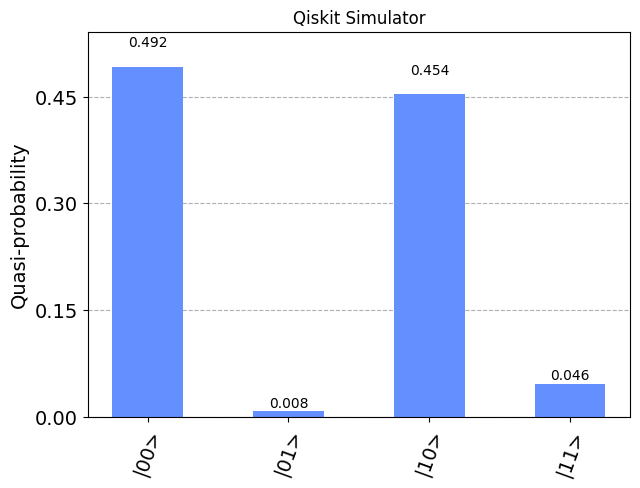

In [275]:
plot_histogram(counts_aer, title = "Qiskit Simulator")

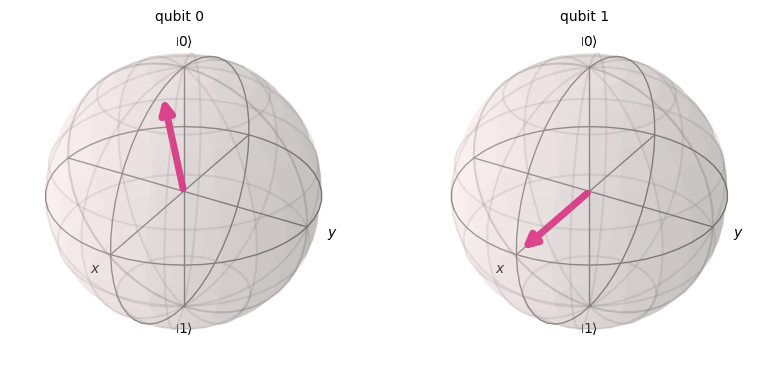

In [251]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


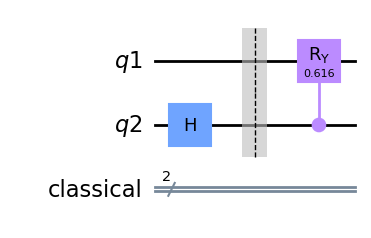

In [247]:
qc.draw('mpl')

In [64]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_qpu.harmony")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=10000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Thu, 04 Jul 2024 12:36:44 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '89df299e2ea4f6ad-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 89df299e2ea4f6ad &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-04 12:36:44 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">89df299e2ea4f6ad</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

In [65]:
result_ionq = job_ionq.result()

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Sun, 07 Jul 2024 04:01:29 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '89f4eeff9c92f5c8-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 89f4eeff9c92f5c8 &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-07 04:01:29 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">89f4eeff9c92f5c8</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

In [8]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

In [9]:
counts_ionq = {"00":4816,"01":178,"10":4438,"11":568}
counts_ionq.items()

dict_items([('00', 4816), ('01', 178), ('10', 4438), ('11', 568)])

15.01905 s
[array([223.09333887, 161.85197892,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\2945423126.py:69: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

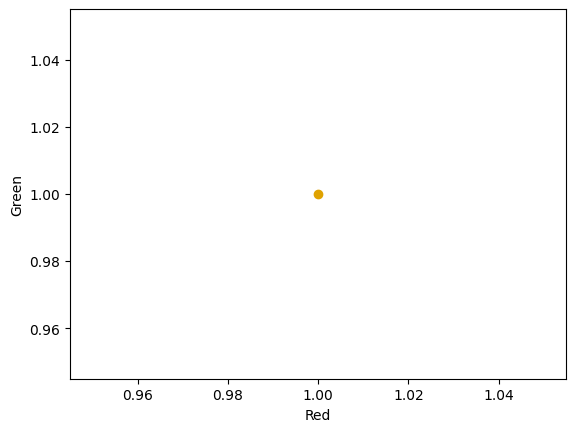

In [10]:
pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [17]:
np.sin(255*np.pi/510) * np.cos(255 * np.pi / (3 *255))

0.5000000000000001

In [18]:
np.sin(255*np.pi/510) * np.sin(255 * np.pi / (3 *255))

0.8660254037844386

In [ ]:
np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))

In [19]:
round(np.arctan2(0.86602,0.50000),4) / 2

0.5236

In [26]:
round(np.arccos(0),4) / 2

0.7854

8.72389 s
[array([253.24032584,   0.        ,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\4293659554.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

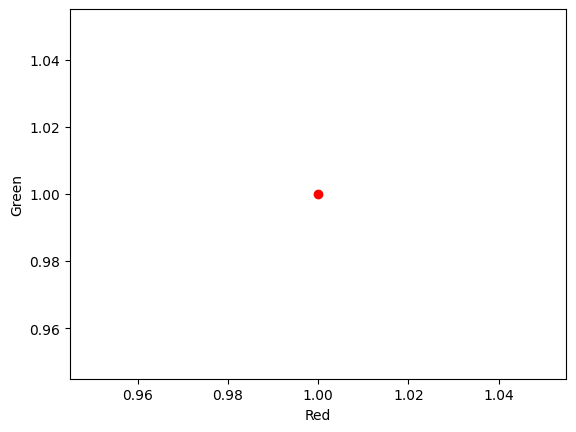

In [131]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

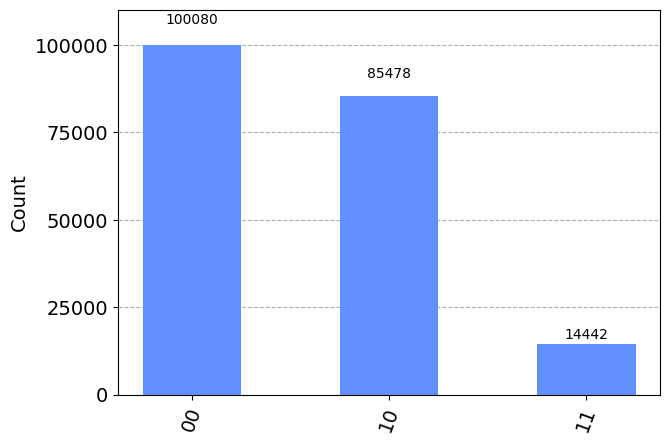

In [132]:
plot_histogram(counts_ionq)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


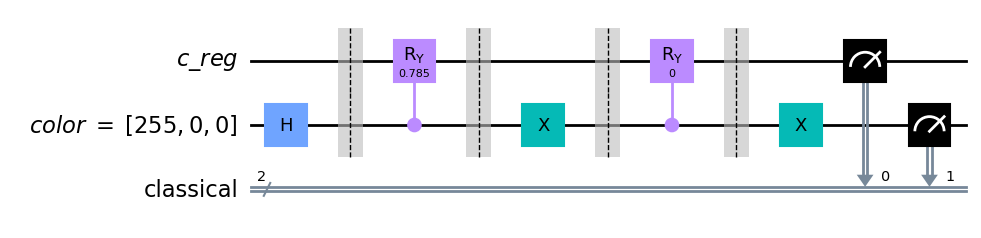

In [133]:
qc.draw('mpl')

In [149]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
#qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
#qc.cry(0,color,c_reg)
qc.barrier()
qc.x(1)

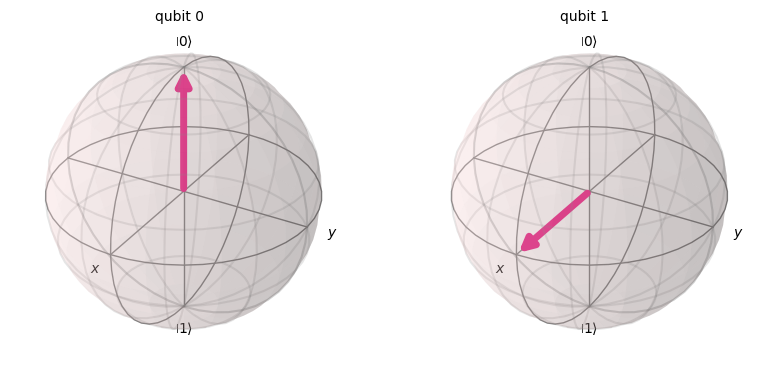

In [150]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\1108092215.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'00': 100053, '10': 99947}


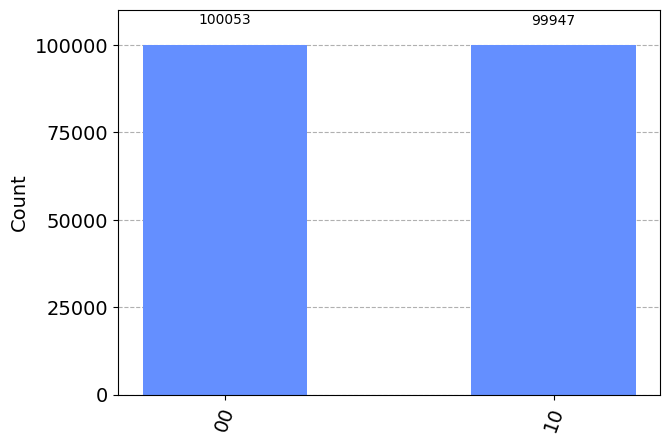

In [151]:
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\3396676026.py:18: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'10': 96252, '00': 99934, '11': 3814}


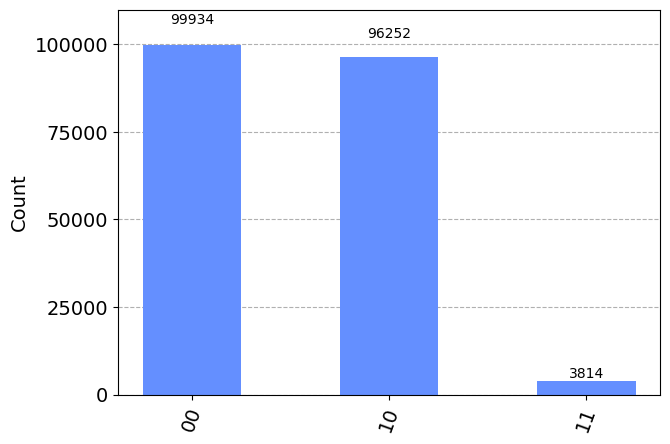

In [177]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
#qc.x(1)
#qc.barrier()
#qc.cry(0,color,c_reg)
#qc.barrier()
#qc.x(1)
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


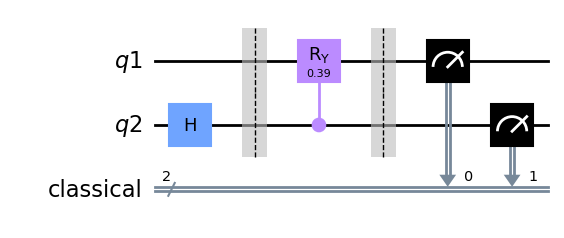

In [178]:
qc.draw('mpl')

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\549445223.py:18: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'00': 98321, '10': 99961, '01': 1718}


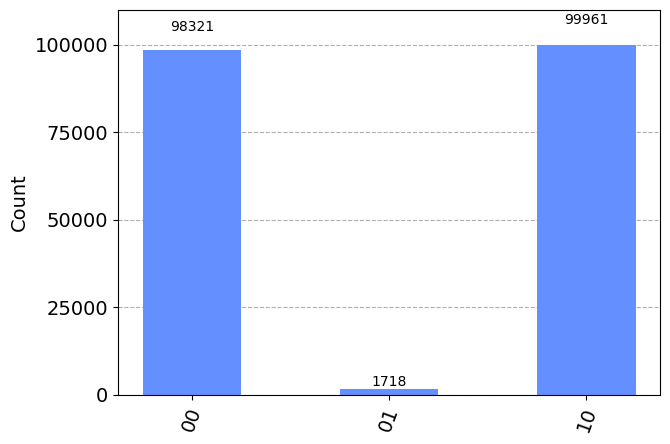

In [181]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
#qc.barrier()
#qc.cry(theta,color,c_reg)
#qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.262,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


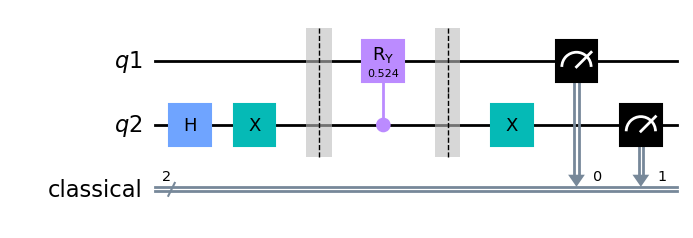

In [180]:
qc.draw('mpl')

In [182]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.262,color,c_reg)
qc.barrier()
qc.x(1)

In [184]:
theta

0.38998918982423

In [190]:
np.pi/4

0.7853981633974483

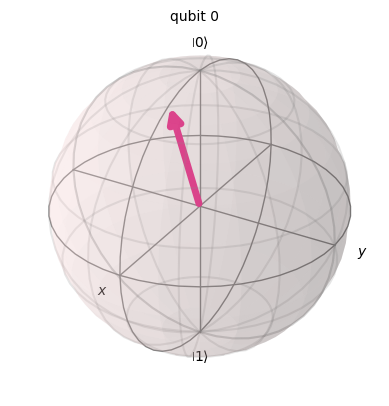

In [188]:
c_reg = QuantumRegister(1,name='q1')

classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg, classic)

qc.barrier()
qc.ry(np.pi/4,c_reg)
qc.barrier()

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

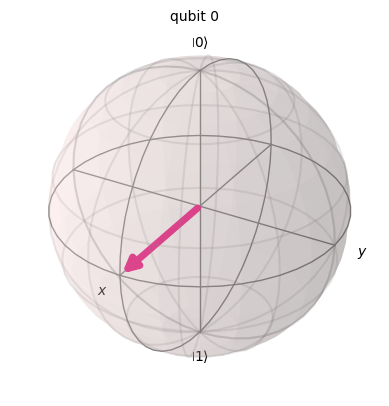

In [191]:
c_reg = QuantumRegister(1,name='q1')

classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg, classic)

qc.barrier()
qc.ry(np.pi/2,c_reg)
qc.barrier()

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

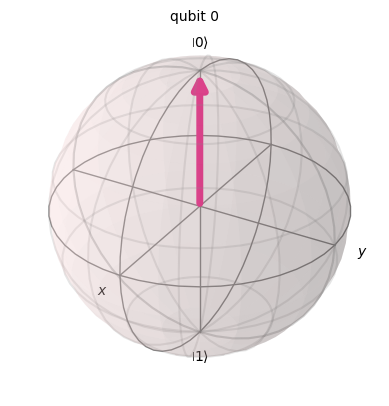

In [189]:
c_reg = QuantumRegister(1,name='q1')

classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg, classic)

qc.barrier()
qc.ry(0,c_reg)
qc.barrier()

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\1829857421.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'10': 96156, '00': 98359, '11': 3819, '01': 1666}


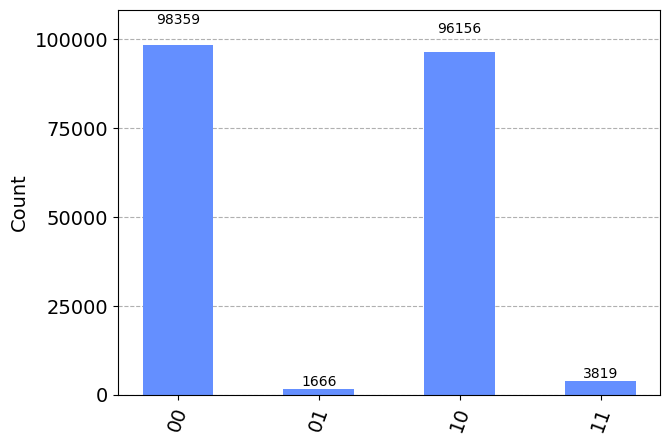

In [183]:
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

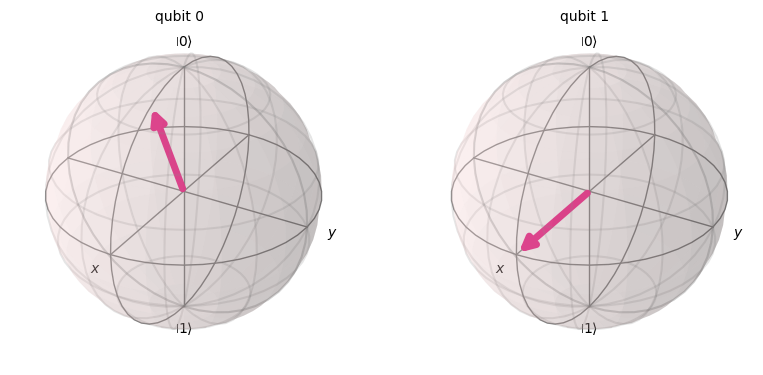

In [158]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

In [172]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
#qc.cry(0.5236,color,c_reg)
qc.barrier()
qc.x(1)

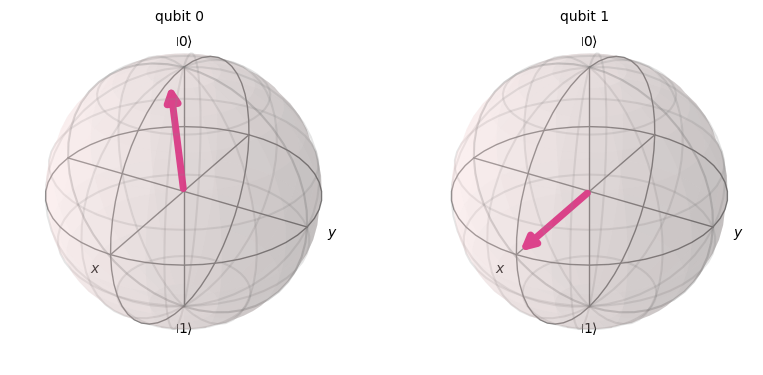

In [173]:
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

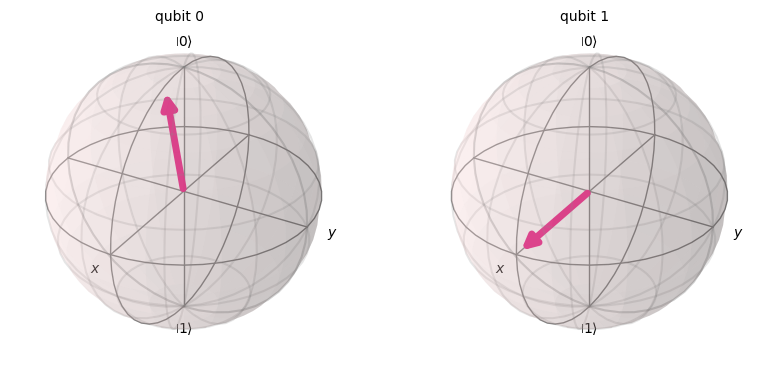

In [171]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
#qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.5236,color,c_reg)
qc.barrier()
qc.x(1)
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

In [ ]:
qc.measure([0,1],[0,1])
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=200000)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

In [164]:
c_reg = QuantumRegister(1,name='q1')
color = QuantumRegister(1, name='q2')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(0.6160,color,c_reg, label='theta')
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(0.2618,color,c_reg, label = 'phi')
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


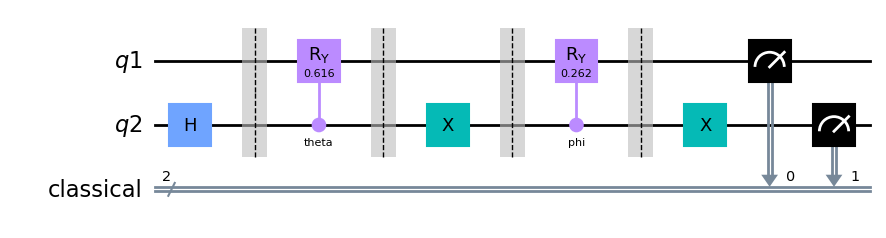

In [165]:
qc.draw('mpl')

In [144]:
from qiskit.circuit.library import mcry

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


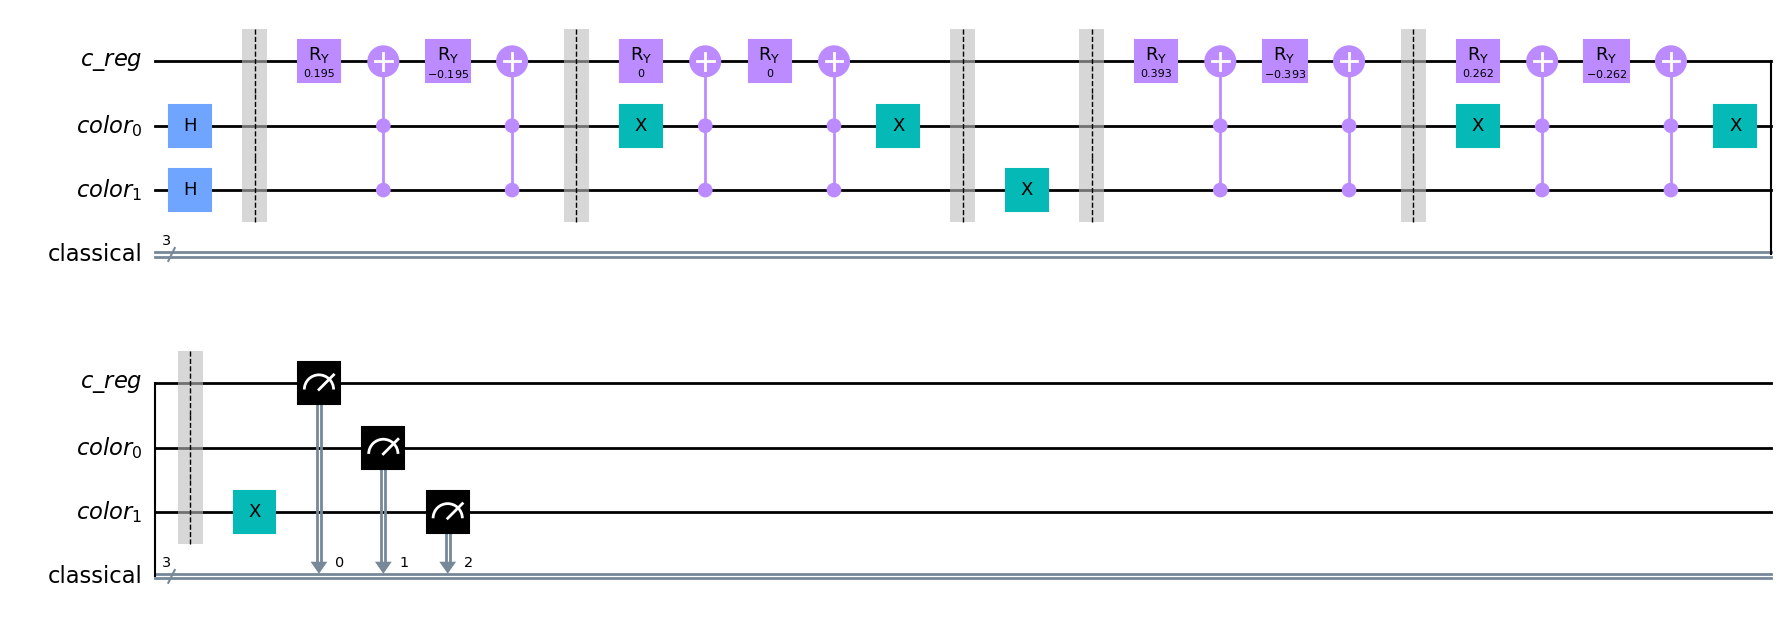

In [145]:
c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(2, name='color')
classic = ClassicalRegister(3, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.h(2)

qc.barrier()
qc.mcry(theta,color,c_reg)

qc.barrier()
qc.x(1)

qc.mcry(0,color,c_reg)

qc.x(1)
qc.barrier()

qc.x(2)
qc.barrier()
qc.mcry(0.785,color,c_reg)
qc.barrier()
qc.x(1)
qc.mcry(0.5236,color,c_reg)
qc.x(1)
qc.barrier()
qc.x(2)


qc.measure([0,1,2],[0,1,2])

qc.draw('mpl')

In [ ]:
c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(2, name='color')
classic = ClassicalRegister(3, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.h(2)

qc.barrier()
qc.mcry(theta,color,c_reg)

qc.barrier()
qc.x(1)

qc.mcry(0,color,c_reg)

qc.x(1)
qc.barrier()

qc.x(2)
qc.barrier()
qc.mcry(0.785,color,c_reg)
qc.barrier()
qc.x(1)
qc.mcry(0.5236,color,c_reg)
qc.x(1)
qc.barrier()
qc.x(2)


qc.measure([0,1,2],[0,1,2])

qc.draw('mpl') 

10.09360 s
[array([426.00562543,   0.        ,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\391213693.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 1.

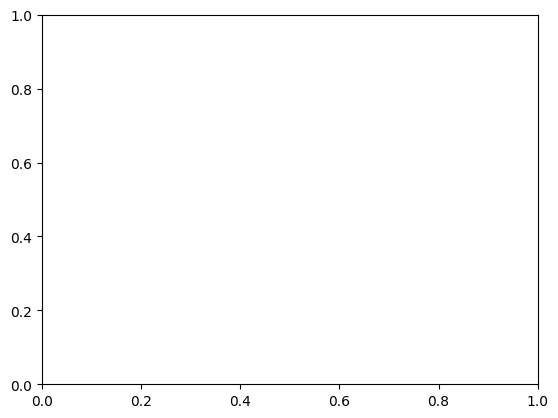

In [28]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta+0.5236,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [32]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

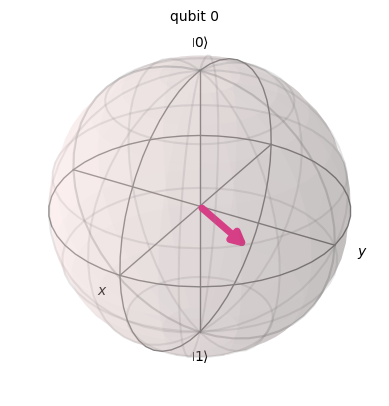

In [42]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.y(0)
state = Statevector.from_instruction(test)
plot_bloch_multivector(state)

In [44]:
from qiskit_aer import AerSimulator

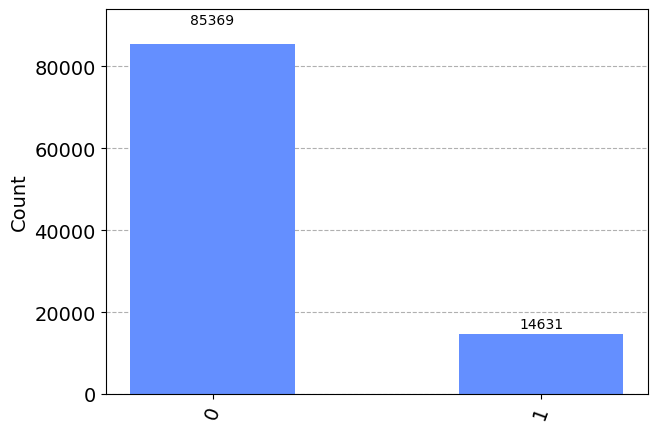

In [49]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [51]:
2 *np.arccos(np.sqrt(85369/(100000)))

0.785011698958968

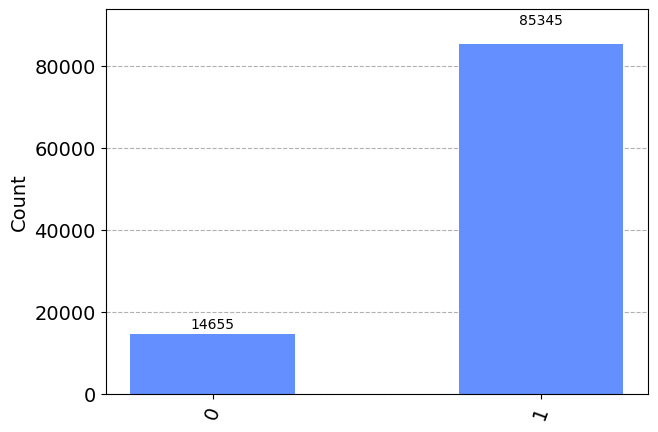

In [52]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [53]:
2 *np.arccos(np.sqrt(14655/(100000)))

2.35590210017568

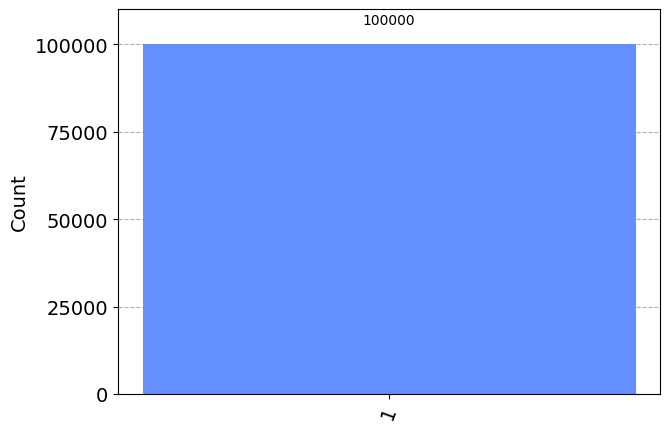

In [54]:
test = QuantumCircuit(1,1)

test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

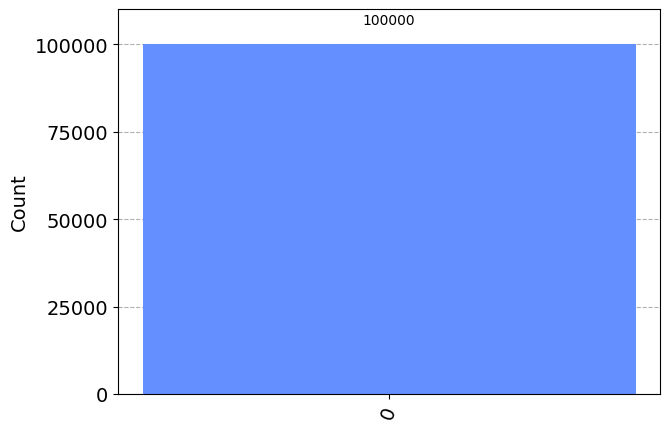

In [55]:
test = QuantumCircuit(1,1)
test.x(0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=100000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

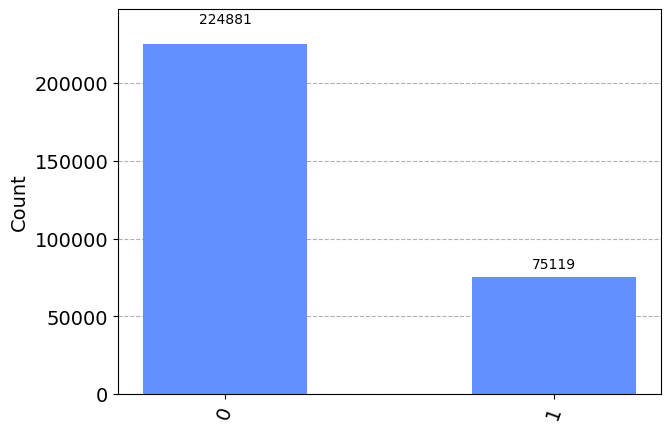

In [64]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.z(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [65]:
2 *np.arccos(np.sqrt(224881/300000))

1.0481133716320996

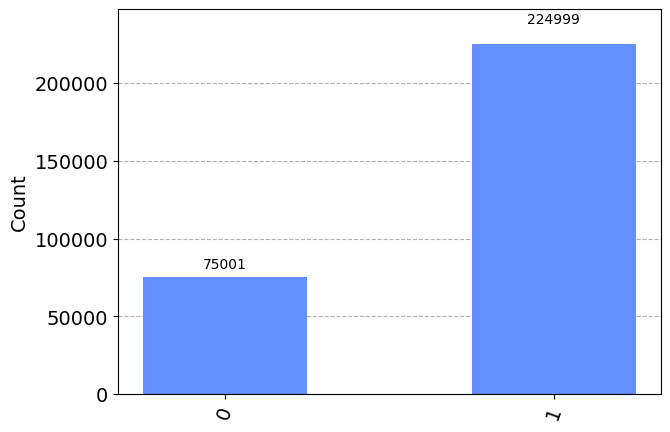

In [66]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.z(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [67]:
2 *np.arccos(np.sqrt(75001/300000))

2.094387404406713

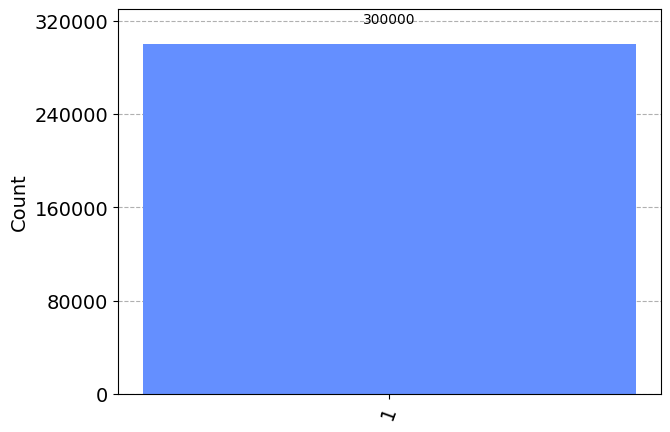

In [68]:
test = QuantumCircuit(1,1)
#test.ry(2*np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [91]:
2 *np.arccos(np.sqrt(0/300000))

3.141592653589793

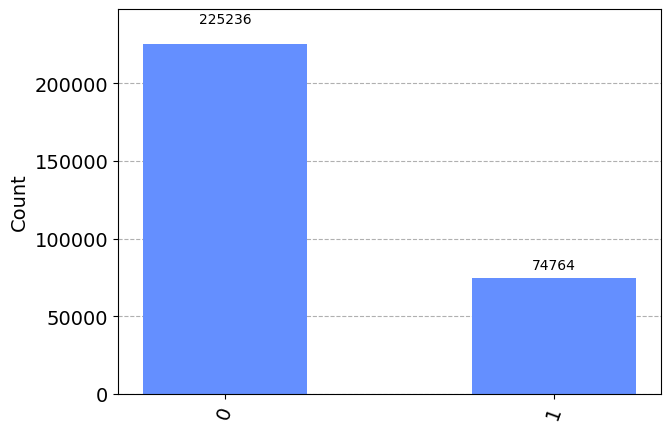

In [74]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [85]:
2*np.arccos(np.sqrt(225236/300000))

1.0453798675738128

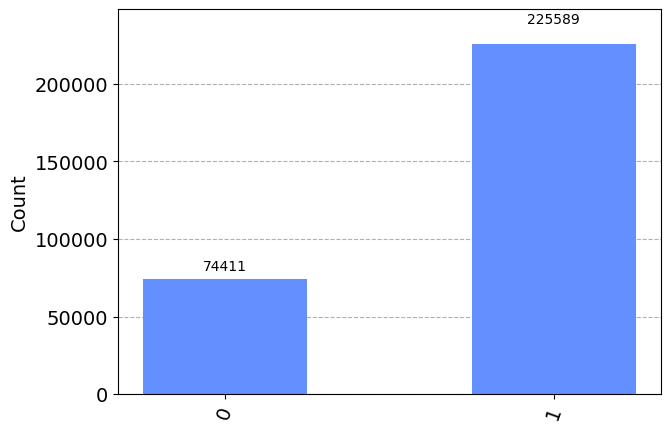

In [77]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [86]:
2 *np.arccos(np.sqrt(74411/300000))

2.0989351923863264

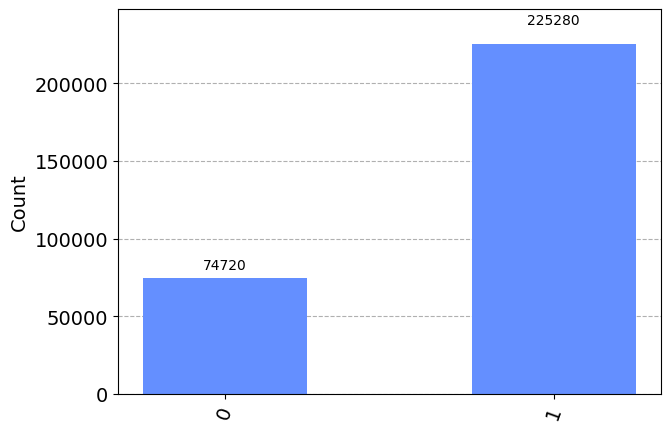

In [88]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [87]:
2*np.arccos(np.sqrt(75012/300000))

2.094302728813224

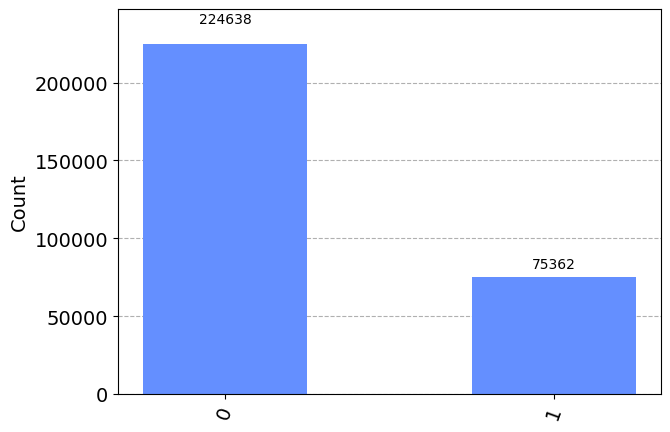

In [89]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [90]:
2*np.arccos(np.sqrt(224947/300000))

1.0476054973568047

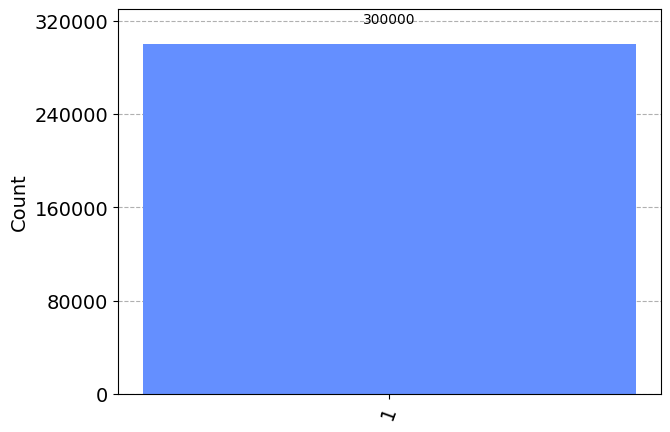

In [92]:
test = QuantumCircuit(1,1)
#test.ry(np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [93]:
2*np.arccos(np.sqrt(0/300000))

3.141592653589793

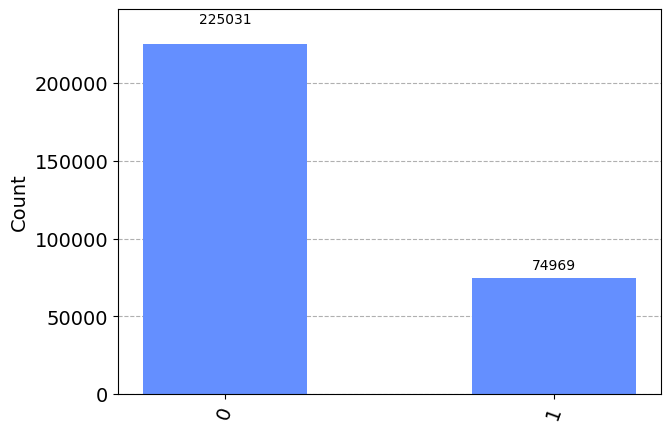

In [98]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)

test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [99]:
2*np.arccos(np.sqrt(225031/300000))

1.046958896641287

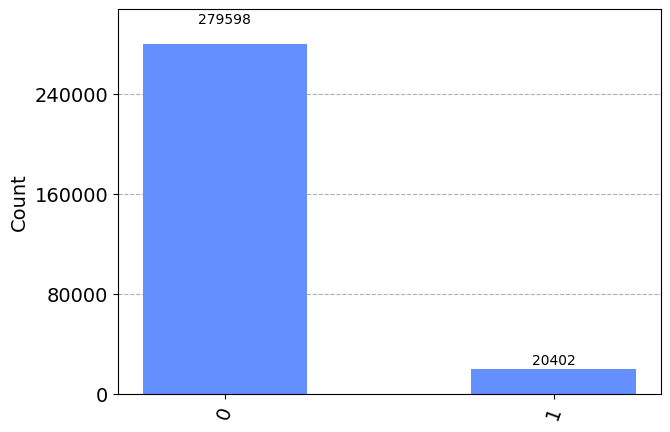

In [116]:
test = QuantumCircuit(1,1)
test.ry(0.5236,0)

test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [117]:
2*np.arccos(np.sqrt(279598/300000))

0.5276619633915896

In [118]:
2*np.arccos(np.sqrt(0/300000))

3.141592653589793

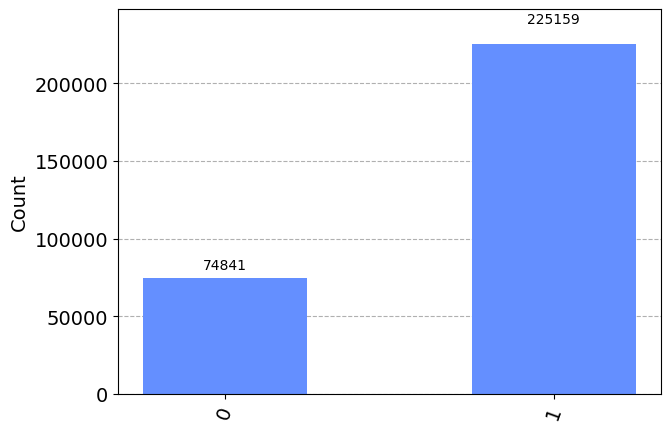

In [94]:
test = QuantumCircuit(1,1)
test.ry(np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

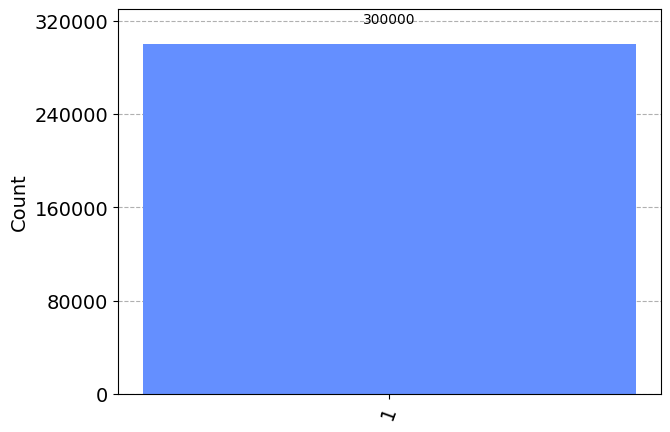

In [119]:
test = QuantumCircuit(1,1)
#test.ry(np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

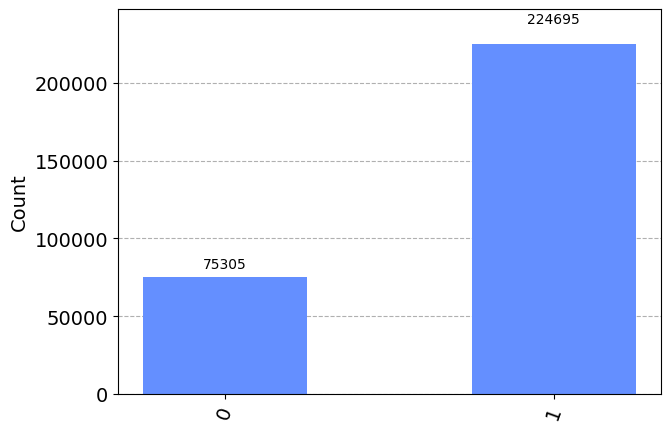

In [128]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
#test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [129]:
2*np.arccos(np.sqrt(75305/300000))

2.092048798342782

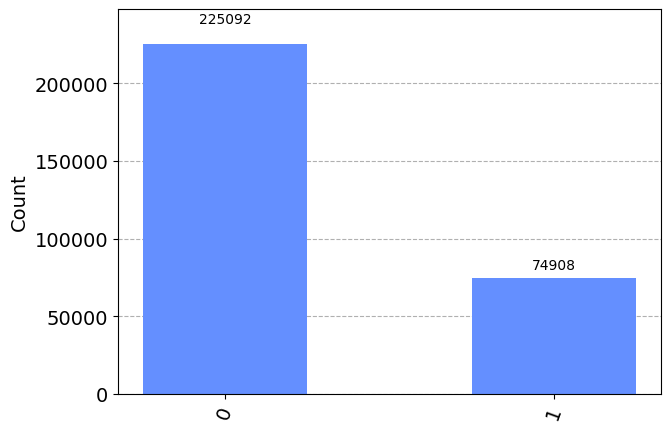

In [130]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [127]:
2*np.arccos(np.sqrt(225325/300000))

1.0446938879044523

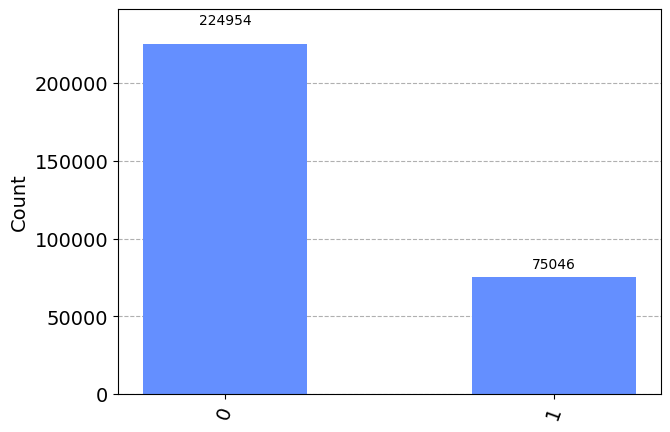

In [96]:
test = QuantumCircuit(1,1)
test.ry(2*np.pi/3,0)
test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [97]:
2*np.arccos(np.sqrt(224954/300000))

1.0475516231787727

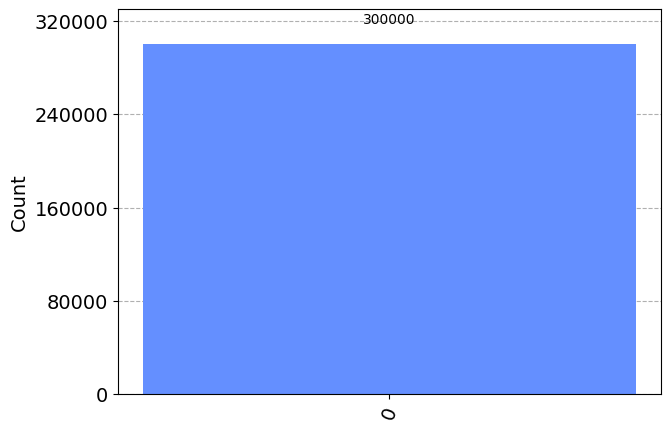

In [100]:
test = QuantumCircuit(1,1)
#test.ry(2*np.pi/3,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

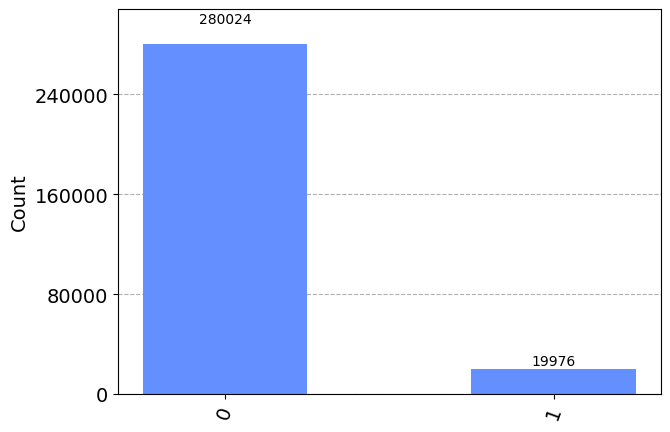

In [101]:
test = QuantumCircuit(1,1)
test.ry(0.5236,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [102]:
2*np.arccos(np.sqrt(280024/300000))

0.5219940189188228

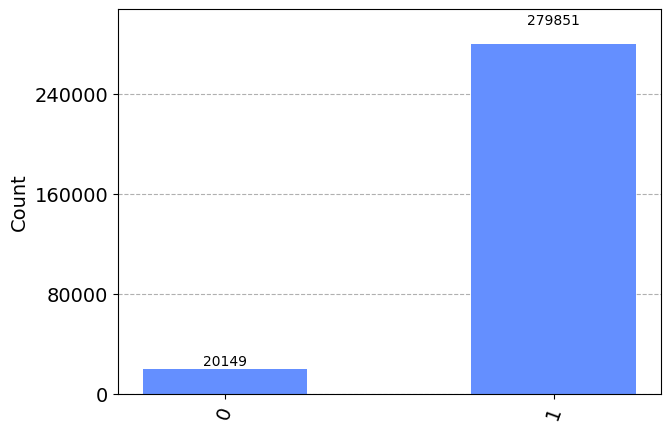

In [104]:
test = QuantumCircuit(1,1)
test.ry(0.5236,0)
test.y(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [105]:
2*np.arccos(np.sqrt(20149/300000))

2.6172901658962426

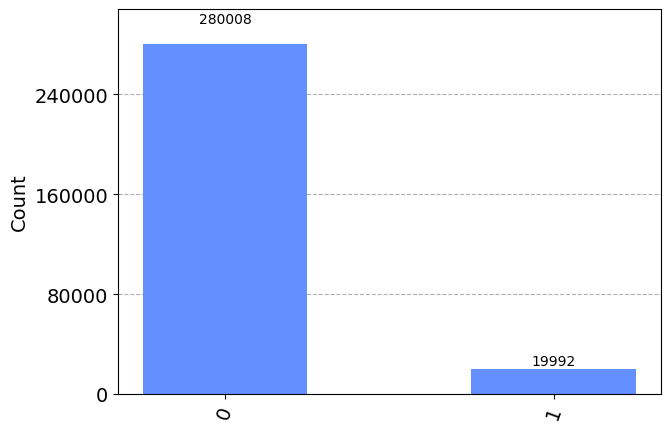

In [103]:
test = QuantumCircuit(1,1)
test.ry(np.pi/6,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [ ]:
5236

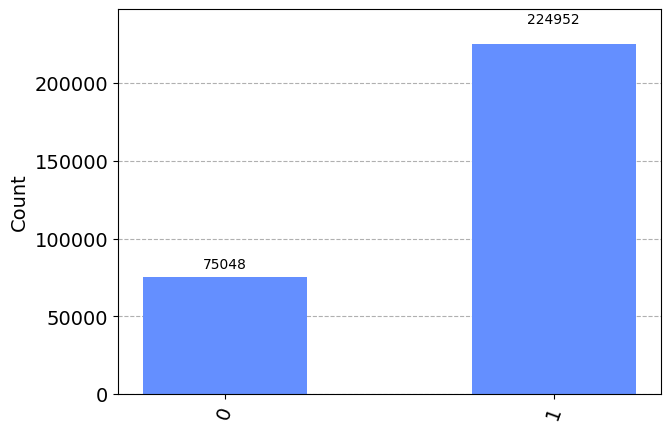

In [108]:
test = QuantumCircuit(1,1)
test.ry(2 * np.pi/3,0)
#test.x(0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [109]:
2*np.arccos(np.sqrt(75048/300000))

2.0940256376178823

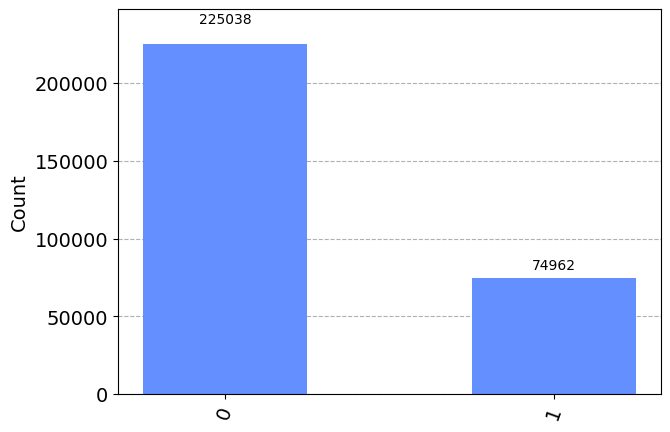

In [114]:
test = QuantumCircuit(1,1)
test.ry( np.pi/3,0)
#test.ry(2 *0.5236,0)
test.measure(0,0)
simulator = AerSimulator()

circ = transpile(test, simulator)

# Run and get counts
result = simulator.run(circ,shots=300000).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [115]:
2*np.arccos(np.sqrt(225038/300000))

1.0469050023498236

In [37]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.measure(0,0)
ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(test, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=100000)
result_ionq = job_ionq.result()
plot_histogram(result_ionq)

AttributeError: Attribute values is not defined

In [38]:
test = QuantumCircuit(1,1)
test.ry(np.pi/4,0)
test.x(0)
test.measure(0,0)
ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(test, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=100000)
result_ionq = job_ionq.result()
plot_histogram(result_ionq)

AttributeError: Attribute values is not defined

# Add rotation with Red color

7.97676 s
[array([253.01645215, 252.18052622,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\215263617.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


Text(0, 0.5, 'Green')

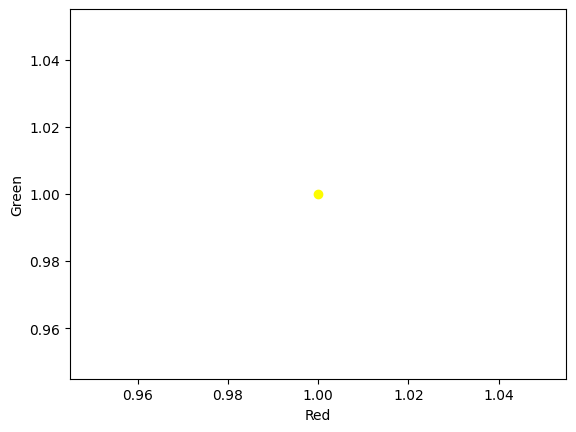

In [23]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi+0.5236,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

20.04725 s
[array([254.25618857, 506.80545368,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\4207986052.py:101: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 1.

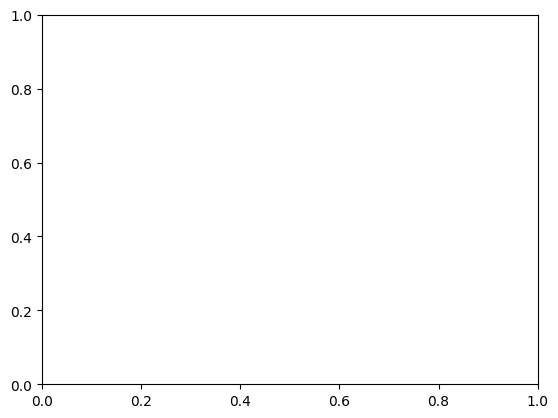

In [24]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi+0.5236*2,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

8.42509 s
[array([765.19447247,   0.        ,   0.        ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_12944\686404906.py:102: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1,1,c=colors_ionq, marker='o')


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 1.

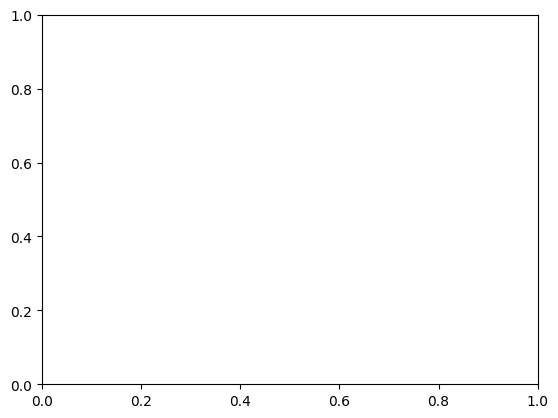

In [25]:
n = 255
k = 0

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [255,0,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.x(c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=200000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [13]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color = [200,100,0]')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_qpu.aria-1")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=10000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

IonQJobStateError: IonQJobStateError('Unable to retreive result for job e299f8d3-3beb-4b02-a425-4b2e6eb96982. Job was cancelled"')

In [16]:
result_ionq = job_ionq.result()

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Sun, 21 Jul 2024 07:29:03 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '8a697a4c3c6df695-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 8a697a4c3c6df695 &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-21 07:29:03 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">8a697a4c3c6df695</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

In [ ]:

counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

In [59]:
error_ionq = []
for i in range(1):
    del_x = recon_color_ionq[0][0] - n
    del_y = recon_color_ionq[0][1] - k
    err_ionq = np.sqrt(del_x**2+del_y**2)
    error_ionq.append(err_ionq)

print("error = ",error_ionq,"time = ", time_ionq)

error =  [24.677950587085036] time =  374.0126967430115


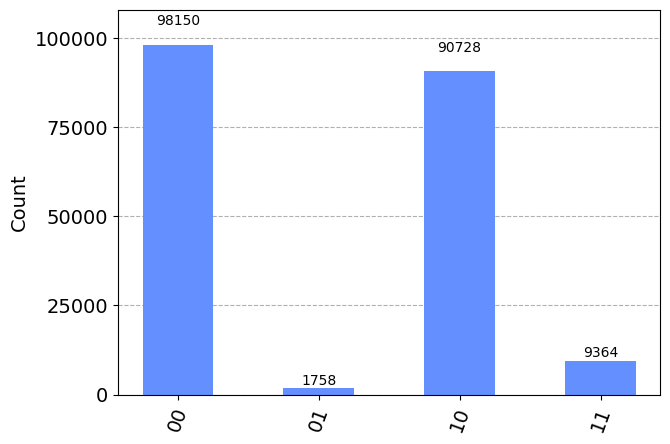

In [54]:
plot_histogram(counts)

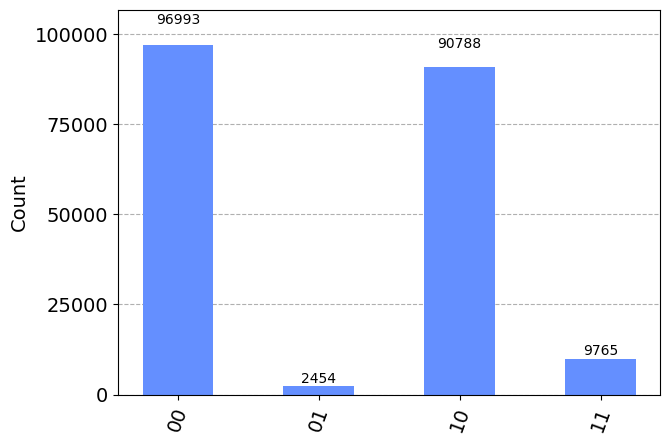

In [56]:
plot_histogram(counts_ionq)

# Aria-1

In [15]:
n = 200
k = 100

start_ionq = time.time()
x = np.sin(n*np.pi/510) * np.cos(k * np.pi / (3 *n))
y = np.sin(n*np.pi/510) * np.sin(k * np.pi / (3 *n))
z = np.cos(n*np.pi/510)
phi = round(np.arctan2(y,x),4) / 2
theta = round(np.arccos(z),4) / 2
Q = np.array([x,y,z])

c_reg = QuantumRegister(1,name='c_reg')
color = QuantumRegister(1, name='color')
classic = ClassicalRegister(2, name = 'classical')
qc = QuantumCircuit(c_reg,color, classic)
qc.h(1)
qc.barrier()
qc.cry(theta,color,c_reg)
qc.barrier()
qc.x(1)
qc.barrier()
qc.cry(phi,color,c_reg)
qc.barrier()
qc.x(1)
qc.measure([0,1],[0,1])

ionq_sim = provider.get_backend("ionq_qpu.aria-1")
t_qc_image = transpile(qc, ionq_sim)
job_ionq = ionq_sim.run(t_qc_image, shots=30000)
result_ionq = job_ionq.result()
counts_ionq = result_ionq.get_counts()

pixel_color_theta_recon = []
pixel_color_phi_recon = []

pixel_color_theta = []
pixel_color_phi = []

for i in range(0, 1):
    for item in counts_ionq.items():
        key = item[0]
        amount = item[1]
        state = key[-1]
        decision = int(key[0])
        bin_coord = key[1:-1]

        if decision == 1:
            pixel_color_theta.append((state, amount))
        elif decision == 0:
            pixel_color_phi.append((state, amount))

# ======================== phi ====================================
total_phi_value = 0
for state in pixel_color_phi:
    state_value = state[1]
    total_phi_value += state_value

phi_state_0 = []
for phi, amount in pixel_color_phi:
    if not int(theta):
        phi_state_0.append((phi, amount))

for i in range(1):
    try:
        theta = np.arccos((phi_state_0[i][1]/total_phi_value)**(1/2))
        pixel_color_phi_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================

total_theta_value = 0
for state in pixel_color_theta:
    state_value = state[1]
    total_theta_value += state_value

theta_state_0 = []
for theta, amount in pixel_color_theta:
    if not int(theta):
        theta_state_0.append((theta, amount))

for i in range(1):
    try:
        theta = np.arccos((theta_state_0[i][1]/total_theta_value)**(1/2))
        pixel_color_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_color_ionq = []
for i in range(len(pixel_color_phi_recon)):
    n_recon_ionq = pixel_color_theta_recon[i] * 1020 / np.pi
    k_recon_ionq = pixel_color_phi_recon[i] * 6 * n_recon_ionq / np.pi
    recon_color_ionq.append(np.array([n_recon_ionq,k_recon_ionq,0]))
end_ionq = time.time()
time_ionq = end_ionq -  start_ionq
print(f'{time_ionq:.5f}', "s")
print(recon_color_ionq)
recon_color__ionq_index = recon_color_ionq[0]
fig = plt.figure()
ax = fig.add_subplot(111)
colors_ionq = recon_color__ionq_index / 255
ax.scatter(1,1,c=colors_ionq, marker='o')
ax.set_xlabel('Red')
ax.set_ylabel('Green')

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=530,headers={'Date': 'Tue, 16 Jul 2024 06:11:15 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '6168', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '8a3fd5762afff57f-NRT'},body=<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Argo Tunnel error | api.ionq.co | Cloudflare</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1033,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1033</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 8a3fd5762afff57f &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2024-07-16 06:11:15 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Argo Tunnel error</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>You've requested a page on a website (api.ionq.co) that is on the <a href="https://www.cloudflare.com/5xx-error-landing/" target="_blank">Cloudflare</a> network. The host (api.ionq.co) is configured as an Argo Tunnel, and Cloudflare is currently unable to resolve it.
            
          </div>

          
          <div id="resolution-copy-section" class="w-1/2 mt-6 text-15 leading-normal">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_can_i_do">What can I do?</h2>
            <p><strong>If you are a visitor of this website:</strong><br />Please try again in a few minutes.</p><p><strong>If you are the owner of this website:</strong><br />Ensure that cloudflared is running and can reach the network. You may wish to enable <a rel="noopener noreferrer" href="https://developers.cloudflare.com/argo-tunnel/reference/load-balancing/">load balancing</a> for your tunnel.</p>
          </div>
          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">8a3fd5762afff57f</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">203.246.113.85</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
,error_type='internal_error')

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


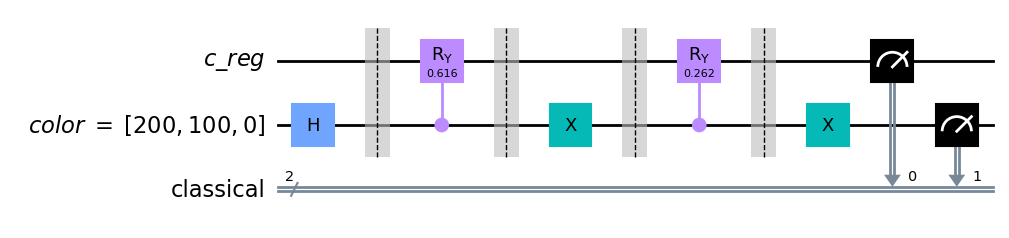

In [57]:
qc.draw('mpl')

In [20]:
color_angle_np = np.array([point[0] for point in color_angle])

# Find unique rows
_, unique_indices = np.unique(color_index_np, axis=0, return_index=True)
color_angle_unique = color_angle_np[unique_indices]

unique_color_list = color_list_unique.tolist()
unique_color_index = color_index_unique.tolist()
unique_color_angle = color_angle_unique.tolist()

In [5]:
for i in range(32):
    color_space = pd.Series(unique_color_list[524288*i:524288*(i+1)], index = pd.Index(unique_color_index[524288*i:524288*(i+1)]))
    color_space.to_excel(f"color_space{i+1}.xlsx", index=True)
for i in range(32):
    color_angle = pd.Series(unique_color_angle[524288*i:524288*(i+1)], index = pd.Index(unique_color_index[524288*i:524288*(i+1)]))
    color_angle.to_excel(f"color_space_angle{i+1}.xlsx", index=True)